# UNET NETWORK (TGS Salt Identification Challenge)

**Import packages**

In [1]:
import os
import time
import datetime
import string
import random
import math
import json
import random
import pandas as pd
import numpy as np
import tensorflow as tf
from skimage.io import imread, imshow
from skimage.transform import resize
import progressbar
tf.reset_default_graph()
import matplotlib
from matplotlib import pyplot as plt
%matplotlib inline
import os
print(os.listdir("../input"))

['sample_submission.csv', 'depths.csv', 'test', 'train.csv', 'train', 'README.md', '.ipynb_checkpoints']


**Set the random seed of numpy and tensorflow**

In [2]:
# np_rand_seed = random.randint(0,100)
# tf_rand_seed = random.randint(0,100)
np_rand_seed = 56
tf_rand_seed = 62
np.random.seed(np_rand_seed)
tf.set_random_seed(tf_rand_seed)
print("numpy random seed: ",np_rand_seed)
print("tensorflow random seed: ", tf_rand_seed)

numpy random seed:  56
tensorflow random seed:  62


**Set some directories**

In [3]:
# input directory
input_dir = '../input'
# directories of train and test images
TRAIN_IMG_DIR = os.path.join(input_dir, 'train')
TEST_IMG_DIR = os.path.join(input_dir, 'test')
# directory of the model files
model_dir = './model_files/'

**Inspect the masks of training set**

In [4]:
masks = pd.read_csv("../input/train.csv")
not_empty = pd.notna(masks.rle_mask)
print(not_empty.sum(), 'masks in', masks[not_empty].id.nunique(), 'images')
print((~not_empty).sum(), 'empty images in', masks.id.nunique(), 'total images')
masks.head(20)

2438 masks in 2438 images
1562 empty images in 4000 total images


,id,rle_mask
0,575d24d81d,NaN
1,a266a2a9df,5051 5151
2,75efad62c1,9 93 109 94 210 94 310 95 411 95 511 96 612 96...
3,34e51dba6a,48 54 149 54 251 53 353 52 455 51 557 50 659 4...
4,4875705fb0,1111 1 1212 1 1313 1 1414 1 1514 2 1615 2 1716...
5,782ae9b7e7,1 1815 1819 90 1920 81 2021 73 2122 64 2223 55...
6,9842f69f8d,NaN
7,aa94cfb806,1 28 102 28 203 29 304 30 405 32 506 33 607 34...
8,50d3073821,1 2121 9293 909
9,28f865caaa,NaN


**Extract ids of train images**

In [5]:
train_ids = masks.id.values
train_ids = np.array(train_ids)

**Extract ids of test images**

In [6]:
test_ids = os.listdir(TEST_IMG_DIR+"/images")
test_ids = np.array(test_ids)

In [7]:
IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS = 128, 128, 3

## 1. Loading and Preprocessing Functions

### 1.1 A function to rle encode a given image mask

In [8]:
def rle_encode(img, min_max_threshold=1e-3, max_mean_threshold=None):
    '''
    img: numpy array, 1 - mask, 0 - background
    Returns run length as string formated
    '''
    if np.max(img) < min_max_threshold:
        return '' ## no need to encode if it's all zeros
    if max_mean_threshold and np.mean(img) > max_mean_threshold:
        return '' ## ignore overfilled mask
    pixels = img.T.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

### 1.2 A function to decode mask rle

In [9]:
def rle_decode(mask_rle, shape=(768, 768)):
    '''
    mask_rle: run-length as string formated (start length)
    shape: (height,width) of array to return 
    Returns numpy array, 1 - mask, 0 - background
    '''
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape).T  # Needed to align to RLE direction

### 1.3 A function to create a single mask for all individual ship masks

In [10]:
def masks_as_image(in_mask_list):
    '''
    Take the individual ship masks and create a mask array for all ships
    '''
    all_masks = np.zeros((768, 768), dtype = np.uint8)
    for mask in in_mask_list:
        if isinstance(mask, str):
            all_masks |= rle_decode(mask)
    return all_masks

### 1.4 A function to encode multiple image masks

In [11]:
def rle_encode_multimage(masks):
    '''
    A function to encode multiples image masks
    '''
    encoded_images = []
    for mask in masks:
        encoded_images.append(rle_encode(mask))
    return encoded_images

### 1.5 A function to binirize mask

In [12]:
def binirize_mask(masks, threshold = 0.5):
    '''
    A function to binirize mask
    '''
    # iterate through each mask
    for n in range(masks.shape[0]):
        # binirize mask
        masks[n] = np.where(masks[n]>threshold, 1, 0)
    # return processed masks
    return masks

### 1.6 A funciton to find the maximum value of the mask

In [13]:
def mask_max_finder(ids, IMG_DIR):
    '''
    A funciton to find the maximum value of the mask
    '''
    maximum = 0
    for id_ in ids: 
        mask_path = IMG_DIR+"/masks/"+id_+".png"
        mask = imread(mask_path, as_gray=True)
        if mask.max()>maximum:
            maximum = mask.max()
    return maximum

### 1.7 A function to generate train/test image batch

In [14]:
def generate_batch(indices, ids, IMG_DIR, IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS, MAX, train_set = False):
    
    '''
    A function to generate train/test image batch
    '''
    
    # extract the id based of train/test set
    batch_ids = ids[indices]
    
    # initialize numpy arrays to hold images and masks 
    X = np.zeros((len(batch_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.float32)
    Y = np.zeros((len(batch_ids), IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.float32)
    
    # iterate through each image
    for n, id_ in enumerate(batch_ids):        
        # construct path for the image
        if train_set:
            img_path = IMG_DIR+"/images/"+id_+".png"
        else:
            img_path = IMG_DIR+"/images/"+id_
        # load image 
        img = imread(img_path)
        # resize image
        img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True, anti_aliasing=False)
        # store the image in the designated numpy array
        X[n] = img.astype(np.float32)
        # del image to save runtime memory
        del(img)
        # if train set is wanted
        if train_set:
            mask_path = IMG_DIR+"/masks/"+id_+".png"
            # extract mask
            mask = imread(mask_path, as_gray=True)
            # divide the mask by maximum value
            mask = mask/MAX
            # resize mask
            mask = resize(mask, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True, anti_aliasing=False)
            # expand dimension
            mask = np.expand_dims(mask, axis=-1)
            # store in the the designated numpy array
            Y[n] = mask.astype(np.float32)
            # delete mask to save runtime memory
            del(mask)

    if train_set:
        return X, Y
    else:
        return X

## 2. Plot sample images and corresponding masks

**Find the maximum of the training set masks**

In [15]:
MAX = mask_max_finder(train_ids, TRAIN_IMG_DIR)

**A function to plot sample images and masks from training set**

In [16]:
def plot_image_and_mask(indices):
    '''
    A function to plot sample images and masks
    '''
    X,Y = generate_batch(indices, train_ids, TRAIN_IMG_DIR, IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS, MAX, train_set=True)
    Y_squeezed = np.squeeze(Y)
    matplotlib.rcParams['figure.figsize'] = (25.0, 20.0)
    plt.subplot(4,4,1)
    plt.title("Image")
    plt.imshow(X[0].astype(np.uint8))
    plt.subplot(4,4,1+4)
    plt.title("Mask")
    plt.imshow(Y_squeezed[0])
    plt.subplot(4,4,2)
    plt.title("Image")
    plt.imshow(X[1].astype(np.uint8))
    plt.subplot(4,4,2+4)
    plt.title("Mask")
    plt.imshow(Y_squeezed[1])
    plt.subplot(4,4,3)
    plt.title("Image")
    plt.imshow(X[2].astype(np.uint8))
    plt.subplot(4,4,3+4)
    plt.title("Mask")
    plt.imshow(Y_squeezed[2])
    plt.subplot(4,4,4)
    plt.title("Image")
    plt.imshow(X[3].astype(np.uint8))
    plt.subplot(4,4,4+4)
    plt.title("Mask")
    plt.imshow(Y_squeezed[3])
    plt.subplot(4,4,9)
    plt.title("Image")
    plt.imshow(X[4].astype(np.uint8))
    plt.subplot(4,4,1+12)
    plt.title("Mask")
    plt.imshow(Y_squeezed[4])
    plt.subplot(4,4,10)
    plt.title("Image")
    plt.imshow(X[5].astype(np.uint8))
    plt.subplot(4,4,2+12)
    plt.title("Mask")
    plt.imshow(Y_squeezed[5])
    plt.subplot(4,4,11)
    plt.title("Image")
    plt.imshow(X[6].astype(np.uint8))
    plt.subplot(4,4,3+12)
    plt.title("Mask")
    plt.imshow(Y_squeezed[6])
    plt.subplot(4,4,12)
    plt.title("Image")
    plt.imshow(X[7].astype(np.uint8))
    plt.subplot(4,4,4+12)
    plt.title("Mask")
    plt.imshow(Y_squeezed[7])
    plt.show()

**Generate random indices and plot sample images and masks**

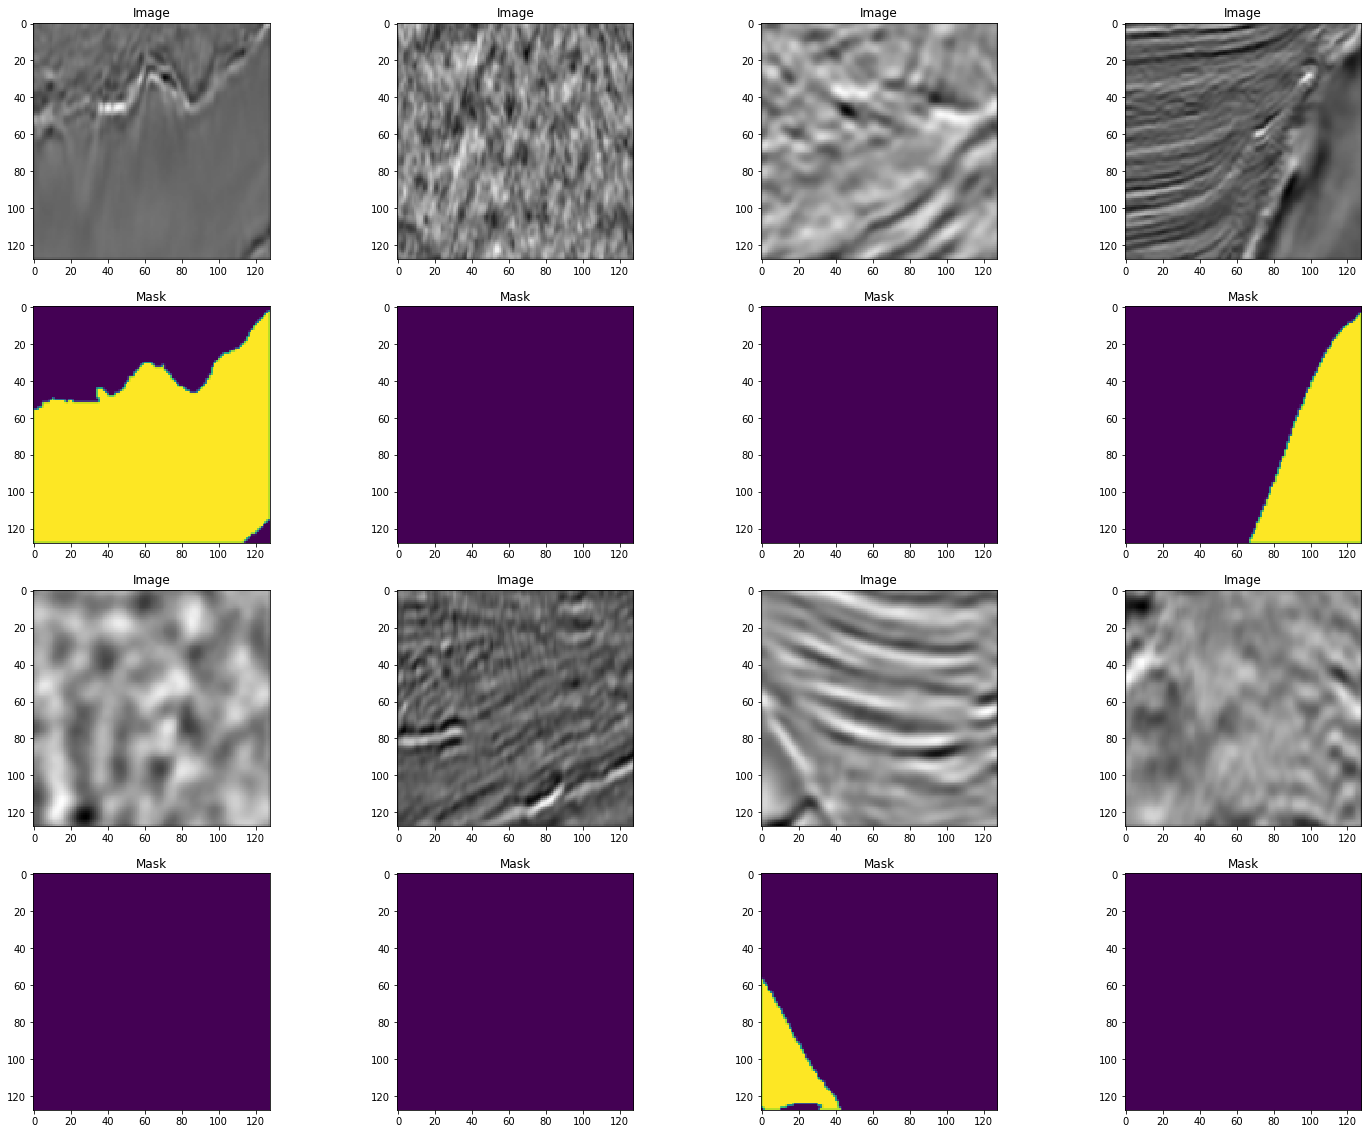

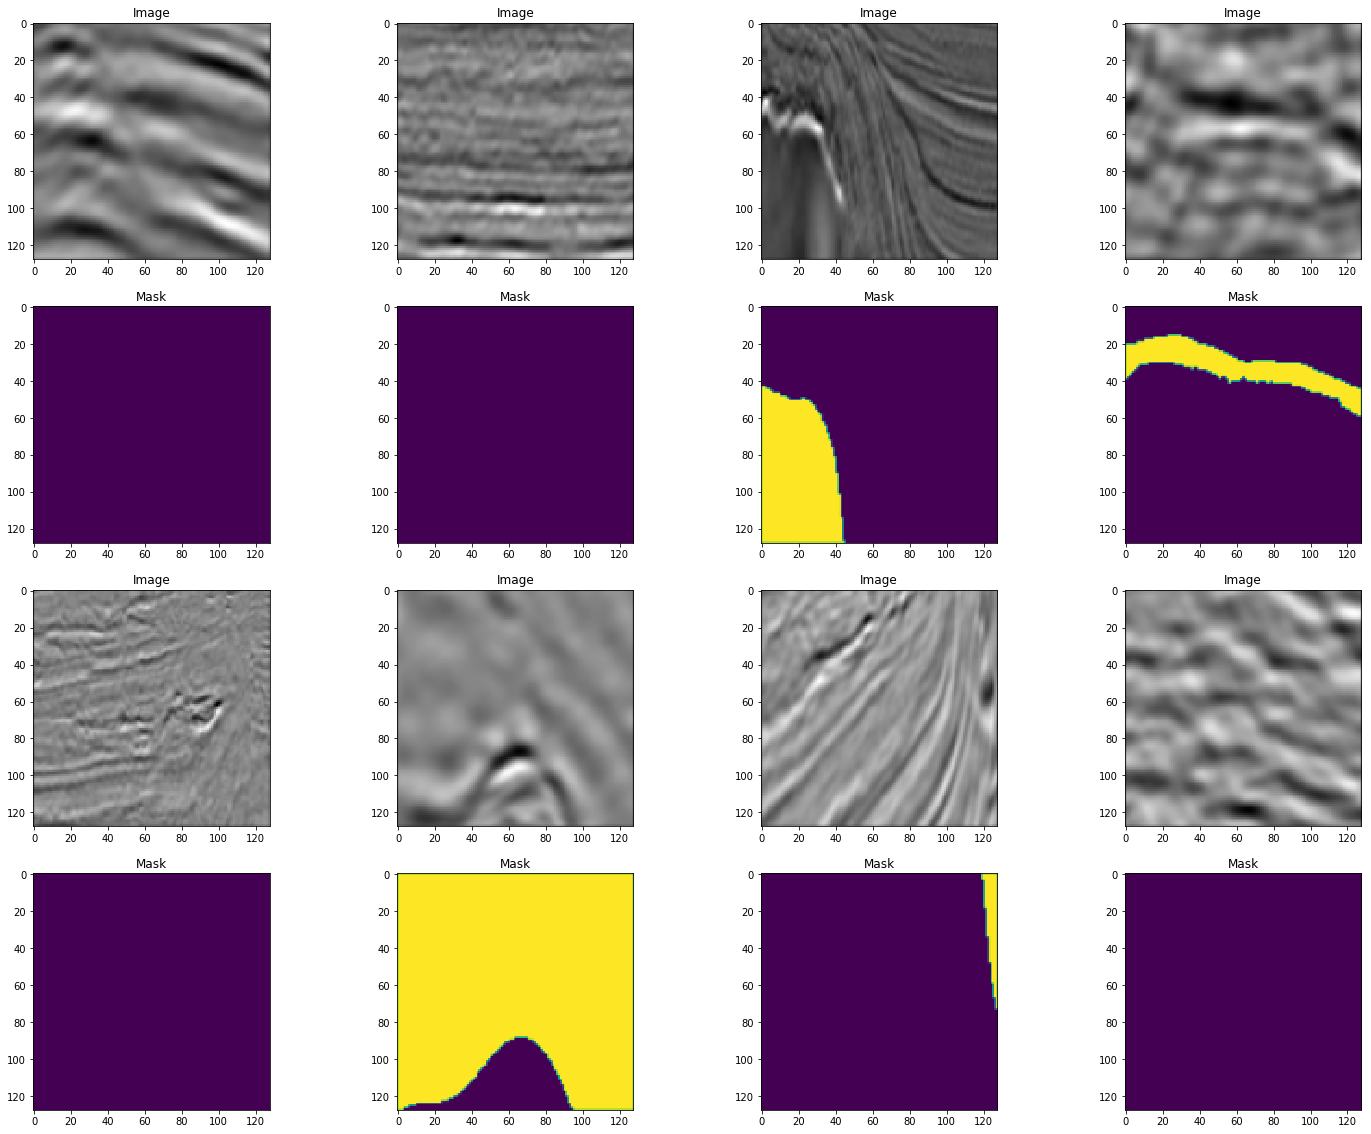

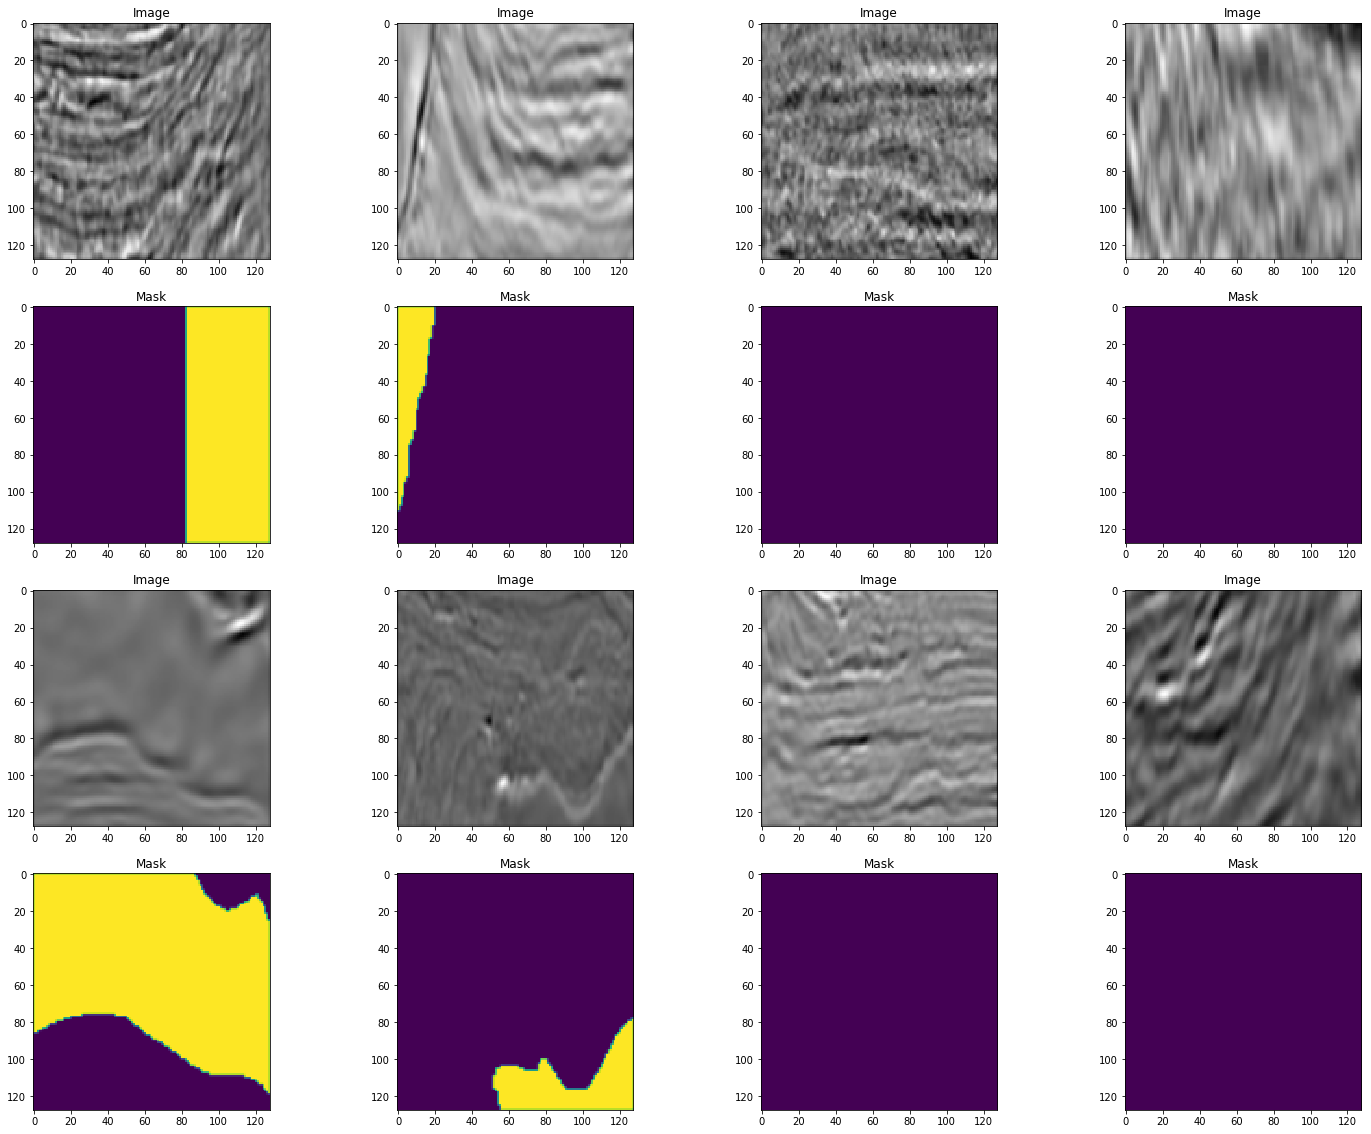

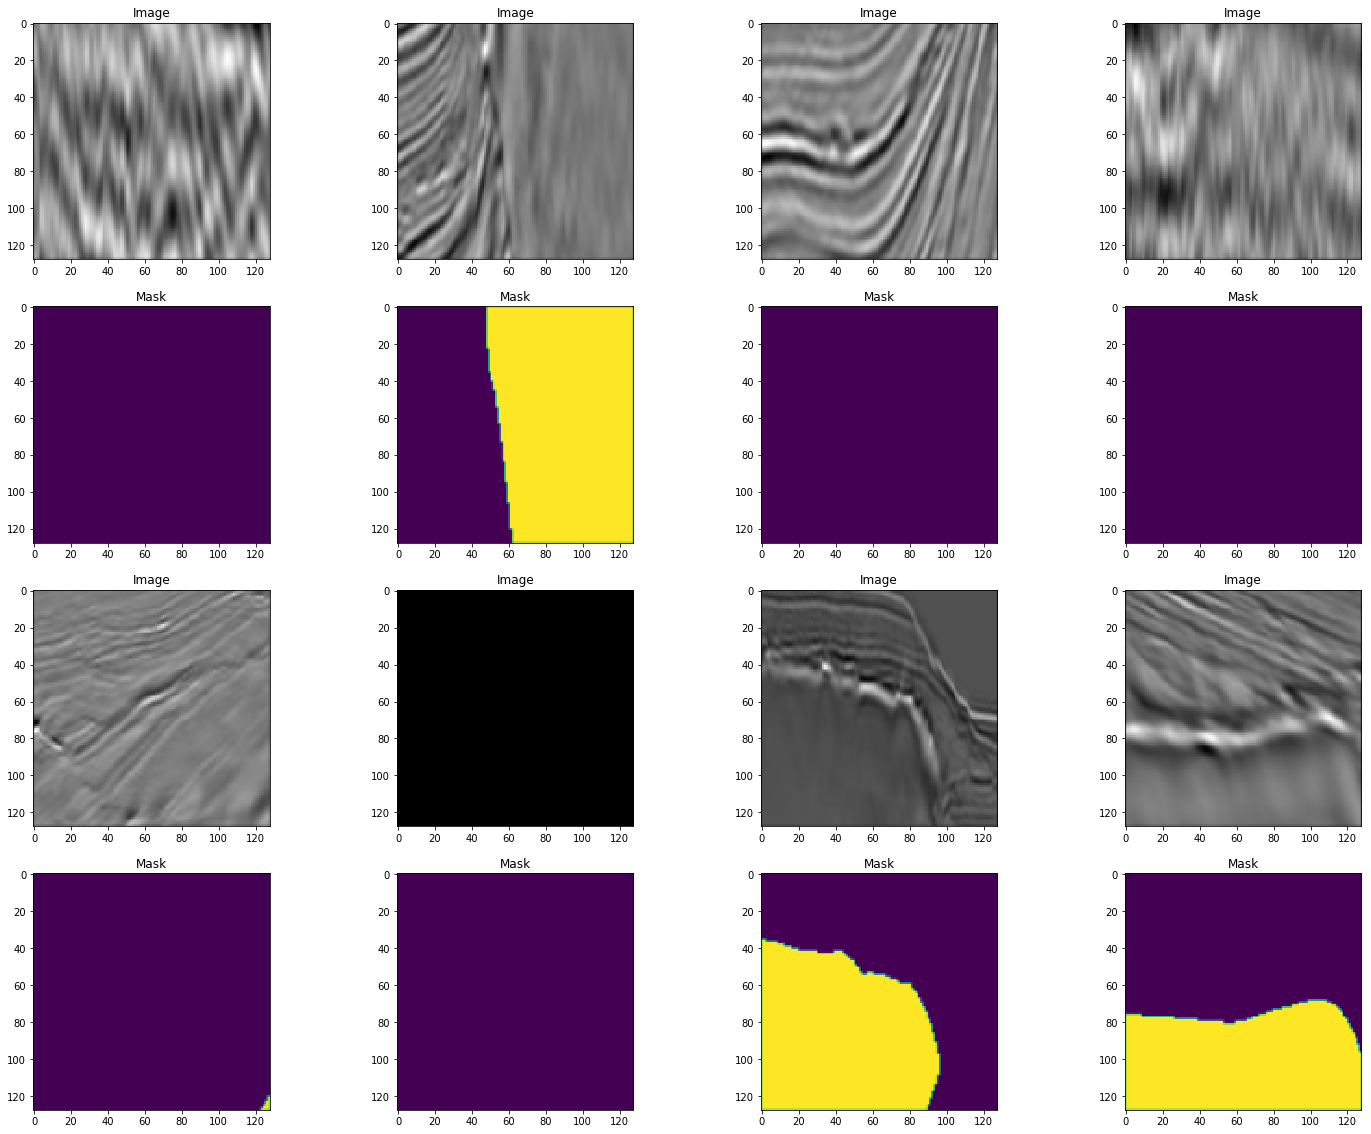

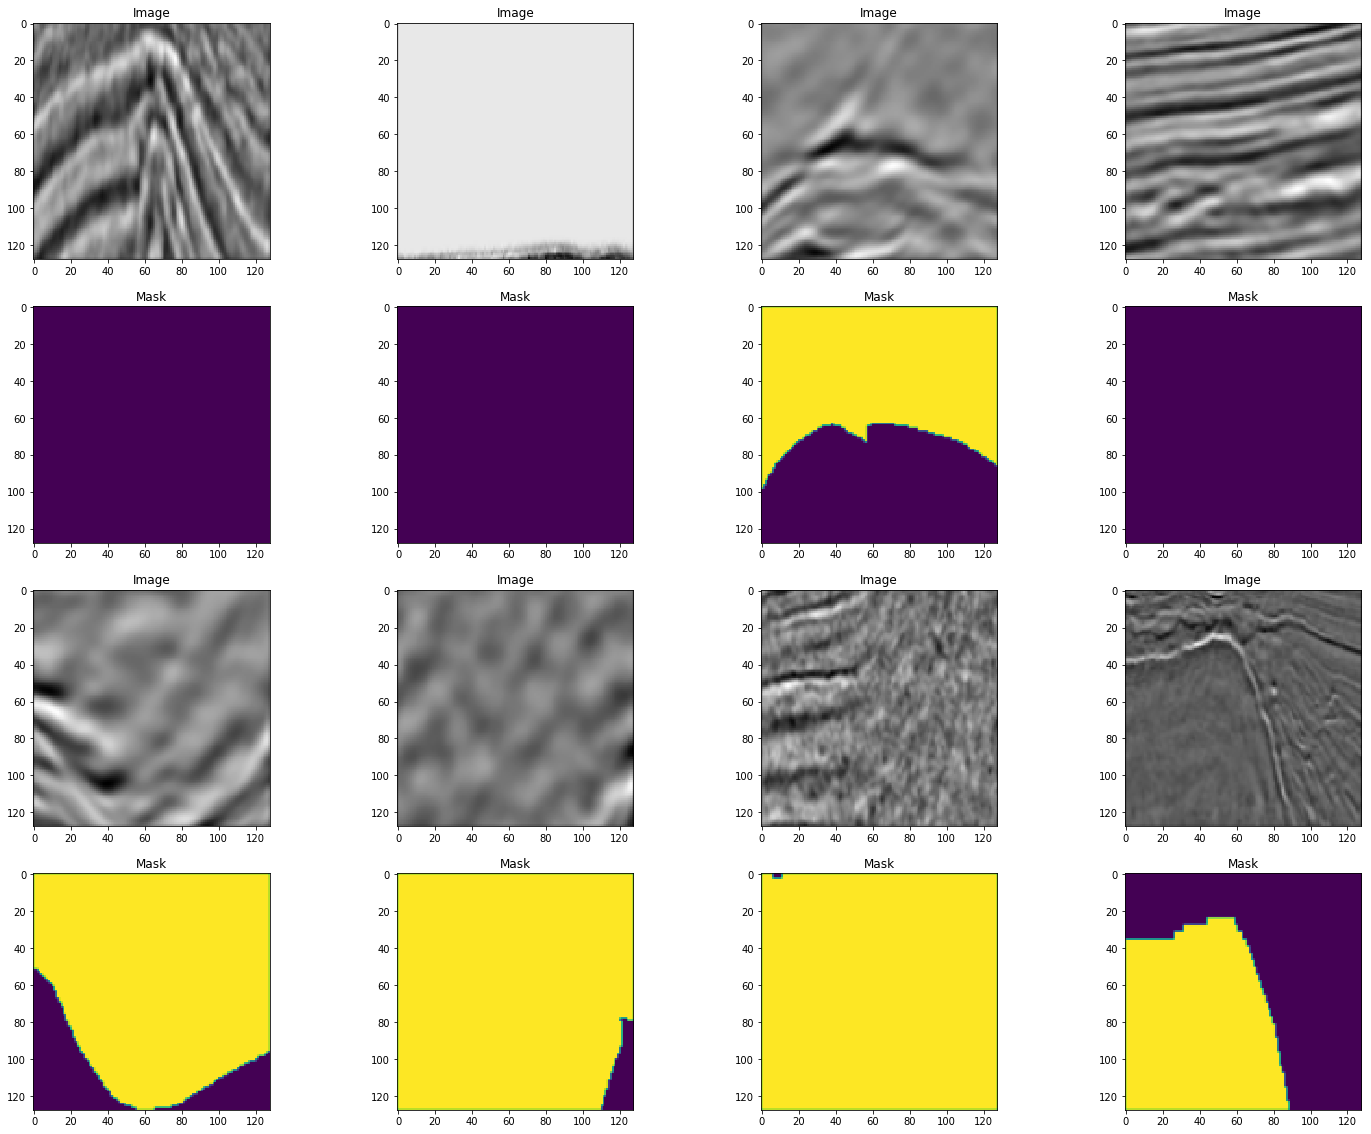

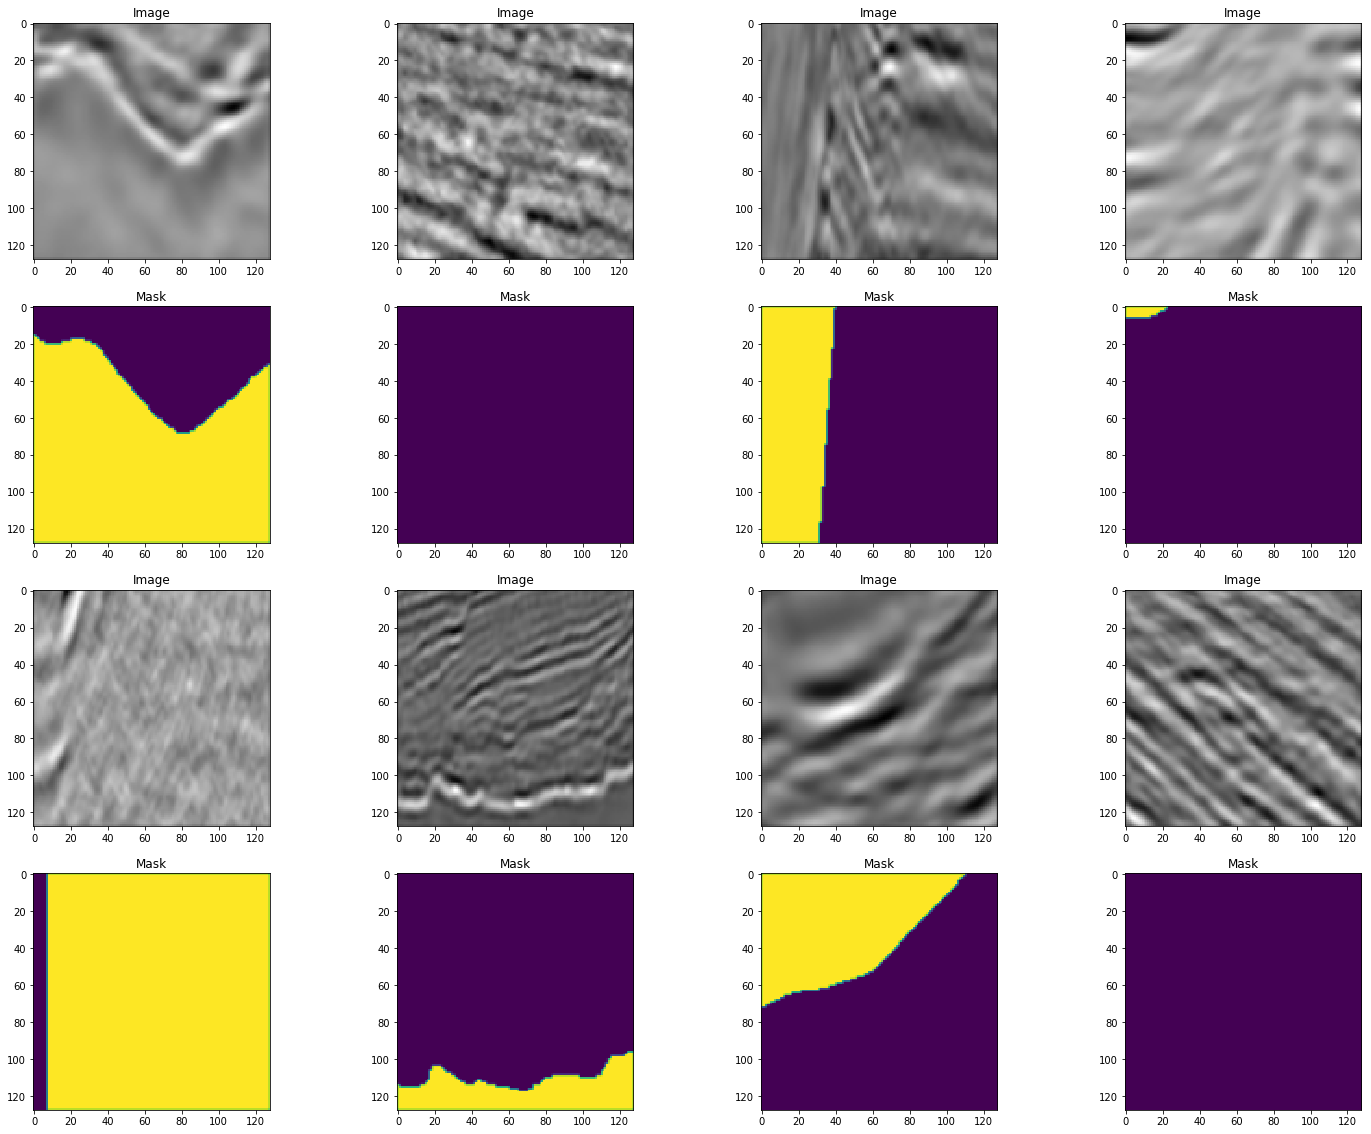

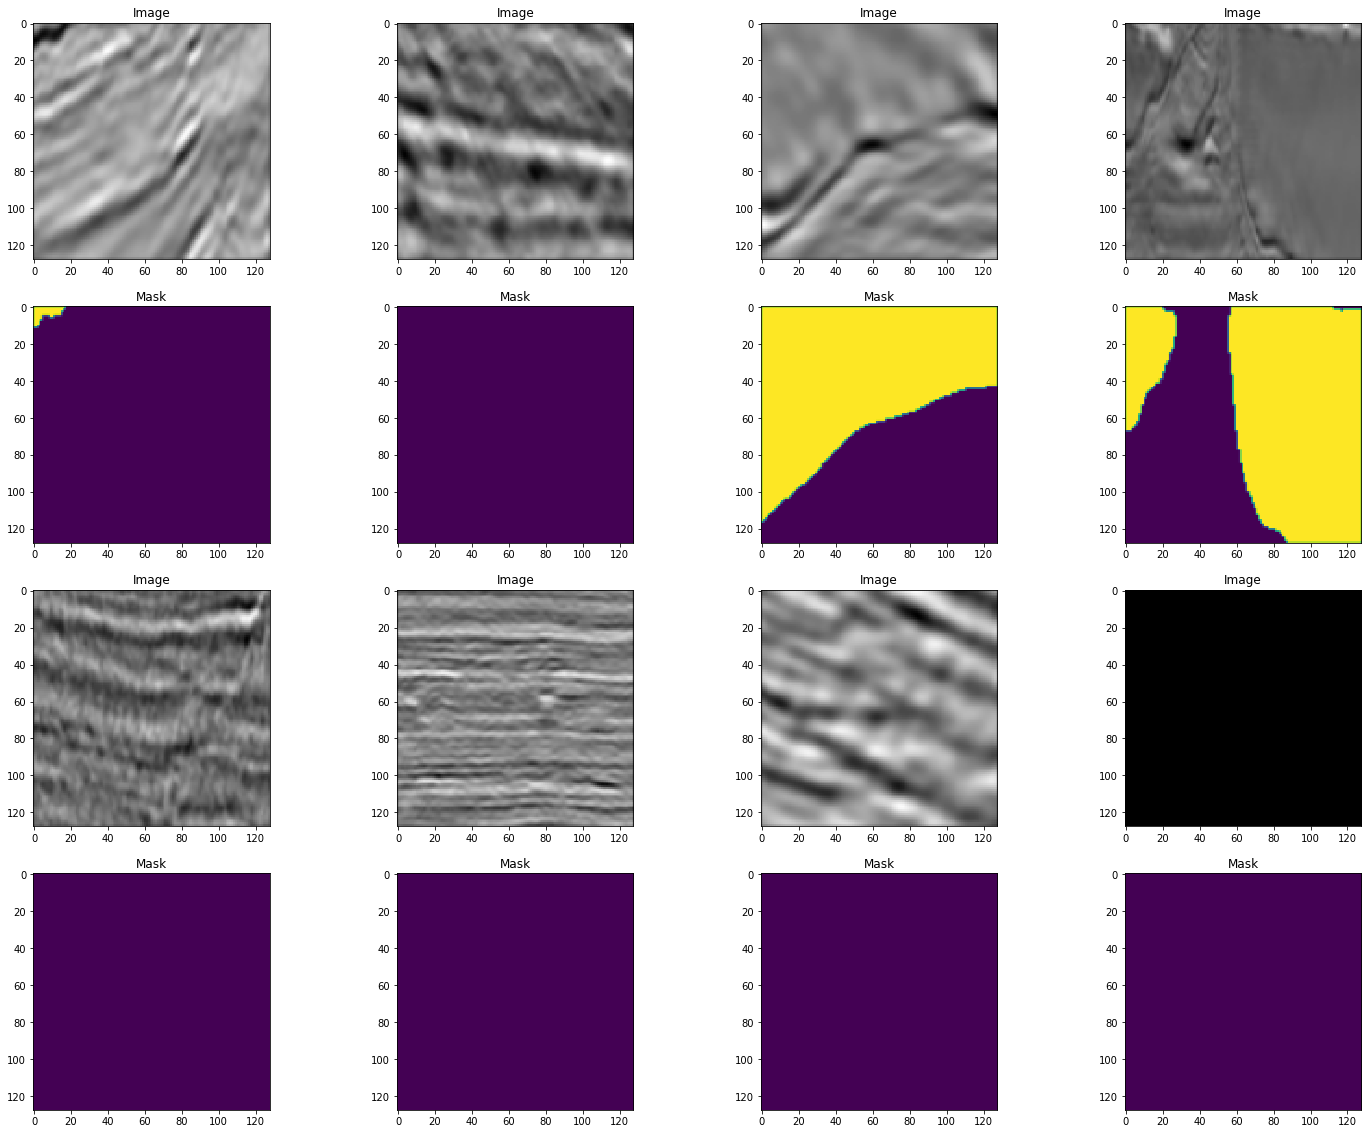

In [17]:
indices = np.random.choice(list(range(len(train_ids))), size=8)
plot_image_and_mask(indices)
indices = np.random.choice(list(range(len(train_ids))), size=8)
plot_image_and_mask(indices)
indices = np.random.choice(list(range(len(train_ids))), size=8)
plot_image_and_mask(indices)
indices = np.random.choice(list(range(len(train_ids))), size=8)
plot_image_and_mask(indices)
indices = np.random.choice(list(range(len(train_ids))), size=8)
plot_image_and_mask(indices)
indices = np.random.choice(list(range(len(train_ids))), size=8)
plot_image_and_mask(indices)
indices = np.random.choice(list(range(len(train_ids))), size=8)
plot_image_and_mask(indices)

## 3. Functions to create UNET network, train UNET network, and create submission csv

**Inspect the devices of kernel**

In [18]:
from tensorflow.python.client import device_lib
devices = device_lib.list_local_devices()
print(devices)

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 1061862883205836169
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 15864515789
locality {
  bus_id: 1
  links {
  }
}
incarnation: 9237197644527177166
physical_device_desc: "device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0"
]


**Set the device to gpu if available**

In [19]:
if len(devices)>1:
    device = devices[1].name
else:
    device = devices[0].name

**Reset the default graph**

In [20]:
tf.reset_default_graph()

### 3.1 A function to create UNET network

In [21]:
def create_unet(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS,
                conv_filters, conv_transpose_filters, kernel_sizes, strides, 
                max_pool_kernel_size, max_pool_strides, learning_rate):
    
    '''
    A function to create UNET network
    '''
    
    # placeholder of input image
    X = tf.placeholder(tf.float32, [None, IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS])
    # placeholder of mask
    Y = tf.placeholder(tf.float32, [None, IMG_HEIGHT, IMG_WIDTH, 1])
    # placeholder for mode of batch normalization
    training = tf.placeholder(tf.bool)
    # a list to store the convolutional layers
    convs = []
    
    print("########################Layers of UNET########################")
    
    # create convolutational layers of UNET using for loop
    for n, conv_filter in enumerate(conv_filters):
        # if it is the 1st convolutional layer
        if n == 0:
            with tf.device(device):
                # conv layer
                conv = tf.layers.conv2d(X, filters=conv_filter, kernel_size=kernel_sizes[n], strides=[strides,strides],
                                        kernel_initializer=tf.variance_scaling_initializer(),padding="SAME", activation=tf.nn.elu)
                # batch normalization layer
                conv = tf.layers.batch_normalization(conv, training=training)
                # max pooling layer
                conv = tf.layers.max_pooling2d(conv, max_pool_kernel_size, max_pool_strides, padding='SAME')
                # append the layer to the designated list
                convs.append(conv)
                print(conv)
        # for rest of the layers
        else:
            with tf.device(device):
                # conv layer
                conv = tf.layers.conv2d(conv, filters=conv_filter, kernel_size=kernel_sizes[n], strides=[strides,strides],
                                        kernel_initializer=tf.variance_scaling_initializer(),padding="SAME", activation=tf.nn.elu)
                # batch normalization layer
                conv = tf.layers.batch_normalization(conv, training=training)
                # max pooling layer
                conv = tf.layers.max_pooling2d(conv, max_pool_kernel_size, max_pool_strides, padding='SAME')
                # if it is not the last convolutional layer
                if n != len(conv_filters)-1:
                    # append the layer to the designated list
                    convs.append(conv)
                print(conv)
    
    # create deconvolutational layers of UNET using for loop
    for n, conv_transpose_filter in enumerate(conv_transpose_filters):
        # if it is not the last layer
        if n != len(conv_transpose_filters)-1:
            with tf.device(device):
                # deconvolutional layer
                conv = tf.layers.conv2d_transpose(conv, filters=conv_transpose_filter, kernel_size=kernel_sizes[::-1][n],
                                                  kernel_initializer=tf.variance_scaling_initializer(),strides=[2,2], padding="SAME", activation=tf.nn.elu)
                # batch normalization layer
                conv = tf.layers.batch_normalization(conv, training=training)
                # concat the corresponding convolutional layer (this improves accuracy)
                conv = tf.concat((conv, convs[::-1][n]), axis=3)
                print(conv)
        # if it is the last layer
        else:
            with tf.device(device):
                # deconvolutional layer
                conv = tf.layers.conv2d_transpose(conv, filters=conv_transpose_filter, kernel_size=kernel_sizes[::-1][n],
                                                  kernel_initializer=tf.variance_scaling_initializer(),strides=[2,2], padding="SAME")
                print(conv)
    
    print("#############################################################")
    
    with tf.device(device):
        # sigmoid of the last deconvolutional layer
        Y_ = tf.nn.sigmoid(conv)
        # flatten the mask
        flat_y = tf.layers.Flatten()(Y)
        # flatten the predicted mask
        flat_conv = tf.layers.Flatten()(conv)
    
    with tf.device(device): 
        # sigmoid_cross_entropy
        loss = tf.losses.sigmoid_cross_entropy(multi_class_labels=flat_y, logits=flat_conv)
        
    # optimizer
    optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
    # update operation
    update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
    
    with tf.control_dependencies(update_ops):
        with tf.device(device):
            # train step
            train_step = optimizer.minimize(loss)
        
    return X,Y,Y_,training,loss,train_step

### 3.2 A function to train UNET network

In [22]:
def train_unet(max_iter,batch_size,
               X,Y,Y_,loss,train_step,training,
               train_indices, feed_dict_validation,
               TRAIN_IMG_DIR, IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS, MAX, model_path):
    
    '''
    A function to traini UNET network
    '''
    
    # start time
    start_time = time.time()

    # create a saver object
    saver = tf.train.Saver(max_to_keep=1)
    
    # lists to store the train loss, validation loss
    train_loss = []
    valid_loss = []

    # variables to store the best loss and best iteration
    best_loss = 100
    best_iteration = None
    
    # number of training data
    N = len(train_indices)
    
    # number of complete batches
    num_complete_mini_batches = math.floor(N/batch_size)

    # create a graph session and optimize the network under it
    with tf.Session() as sess:

        sess.run(tf.global_variables_initializer())
        
        # create an object of progress bar
        bar = progressbar.ProgressBar(maxval=max_iter, widgets=[
            '[',progressbar.Percentage(),']',
            progressbar.Bar(),
            '(',progressbar.DynamicMessage("train_loss"),')',
            '(',progressbar.DynamicMessage("valid_loss"),')',
            '(',progressbar.DynamicMessage("time_elapsed"),'mins)'
        ])
        # start the progress bar
        bar.start()
        # counter variable to track the number of iterations
        counter = 0
        # iterate until maximum number of iterations is reached
        while True:            
            # break out of the inner for loop if maximum number of iterations is reached
            if counter>=max_iter:
                break
            # iterate through the mini batches
            for k in range(0, num_complete_mini_batches+1):
                # if the mini batch is a complete batch
                if k < num_complete_mini_batches:
                    batch_indices = np.array(list(range(k * batch_size, k * batch_size + batch_size)))
                # handling the end case when the last mini batch is less than the batch_size
                elif N % batch_size != 0:
                    batch_indices = np.array(list(range(num_complete_mini_batches * batch_size, N)))
                    
                # generate images and masks for the batch
                image_batch, mask_batch = generate_batch(batch_indices, train_ids, TRAIN_IMG_DIR,
                                                         IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS, MAX,train_set=True)
                   
                # feed dict of the batch
                feed_dict_batch =  {X: image_batch.astype(np.float32), Y: mask_batch.astype(np.float32), training: True}

                # execute optimization step
                sess.run(train_step, feed_dict=feed_dict_batch)

                # calculate temporary train loss and append it to the designated list
                temp_train_loss = loss.eval(session=sess, feed_dict=feed_dict_batch)
                train_loss.append(temp_train_loss)

                # calculate temporary validation loss and append it to the designated list
                temp_validation_loss = loss.eval(session=sess, feed_dict=feed_dict_validation)
                valid_loss.append(temp_validation_loss)

                # if valid loss is better than best recorded so far then
                # update the parameters of the best model and save the model
                if temp_validation_loss < best_loss:
                    best_loss = temp_validation_loss
                    best_iteration = counter+1          
                    saver.save(sess, model_path, global_step = best_iteration)
                    
                # compute running time from start point
                time_diff = (time.time()-start_time)/60
                # update the progress bar
                bar.update(counter+1, train_loss = temp_train_loss, valid_loss = temp_validation_loss, time_elapsed = time_diff)
                # increment counter variable
                counter += 1
                # break out of the inner for loop if maximum number of iterations is reached
                if counter>=max_iter:
                    break        
        # finish the progress bar
        bar.finish()
            
    return saver, train_loss, valid_loss, best_loss, best_iteration

### 1.3 A function to create predictions and submission file

In [23]:
def create_predictions(model_path, X, training, test_ids, n_folds, 
                       threshold, submission_path = "./submission_files/submission.csv"):
    
    '''
    A function to create predictions and submission file
    '''

    with tf.Session() as sess:
        
        # restore the best model
        saver.restore(sess, model_path)

        # number of test samples
        n = len(test_ids)
        # step size of each fold
        step = n//n_folds
        # a list to store the encoded pixels 
        EncodedPixels = []
        # create a progress bar object
        bar = progressbar.ProgressBar(maxval=n_folds, widgets=[
                        '[',progressbar.Percentage(),']',
                        progressbar.Bar(),
                        '(',progressbar.DynamicMessage("number_of_folds_completed"),')'
                    ])
        # start progress bat
        bar.start()

        # iterate through each fold
        for i in range(n_folds):
            # start and end indices of the fold
            if i != (n_folds-1):
                start = (step*i)
                end = (step*(i+1)) 
            else:
                start = (step*i)
                end = len(test_ids)

            # create array of indices
            indices = list(range(start, end))
            indices = np.array(indices)

            # generate batch of test data
            image_test_batch = generate_batch(indices, test_ids, TEST_IMG_DIR, 
                                              IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS, 
                                              MAX, train_set=False)
            # feed dict for test batch
            feed_dict_test =  {X: image_test_batch.astype(np.float32), training: False}
            # compute predicted masks
            mask_predicted = sess.run(Y_, feed_dict=feed_dict_test)
            # binirize masks
            mask_predicted = binirize_mask(mask_predicted, threshold=threshold)
            # encode masks
            EncodedPixels = rle_encode_multimage(mask_predicted)
            
            # save the predictions to the designated csv file
            if i == 0:
                submission = pd.DataFrame({"id":test_ids[indices],"rle_mask": EncodedPixels}, columns=["id","rle_mask"])
                submission.id = submission.id.fillna('')
                submission.to_csv(submission_path, header = True, index=False)
            else:
                submission = pd.DataFrame({"id":test_ids[indices],"rle_mask": EncodedPixels}, columns=["id","rle_mask"])
                submission.id = submission.id.fillna('')
                submission.to_csv(submission_path, mode='a', header = False, index=False) 

            # update the progress bar
            bar.update(i+1, number_of_folds_completed = i+1)
            
        # finish the progress bar
        bar.finish()

## 4. Create and train UNET network

**Create train and validation indices**

In [24]:
train_indices = np.random.choice(len(train_ids), round(len(train_ids)*0.95), replace=False)
validation_indices = np.array(list(set(range(len(train_ids))) - set(train_indices)))
print("Size of train set:", len(train_indices))
print("Size of validation set:", len(validation_indices))

Size of train set: 3800
Size of validation set: 200


In [25]:
# kernel sizes of conv and deconv layers
kernel_sizes = [7,7,5,3]
# number of filters of each conv layer
conv_filters = [16,32,64,128]
# stride 
strides = 1
# max pool kernel size and strides
max_pool_kernel_size = 2
max_pool_strides = 2
# number of filters of each deconv layer 
conv_transpose_filters = [128,64,32,1]
learning_rate=0.0001
# batch size
batch_size = 200
# max iteration
max_iter = 3000

# create unet
X,Y,Y_,training,loss,train_step = create_unet(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS,
                                              conv_filters, conv_transpose_filters, kernel_sizes, strides,
                                              max_pool_kernel_size, max_pool_strides, learning_rate)

# create feed dict for validation 
image_validation, mask_validation =  generate_batch(validation_indices, train_ids, TRAIN_IMG_DIR, IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS, MAX, train_set=True)
feed_dict_validation =  {X: image_validation.astype(np.float32), Y: mask_validation.astype(np.float32), training: False}

# train unet
model_path = model_dir+'my-model'
saver, train_loss, valid_loss, best_loss, best_iteration = train_unet(max_iter,batch_size,
                                                                      X,Y,Y_,loss,train_step,training,
                                                                      train_indices, feed_dict_validation,
                                                                      TRAIN_IMG_DIR, IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS, MAX, model_path)

########################Layers of UNET########################
Tensor("max_pooling2d/MaxPool:0", shape=(?, 64, 64, 16), dtype=float32, device=/device:GPU:0)
Tensor("max_pooling2d_1/MaxPool:0", shape=(?, 32, 32, 32), dtype=float32, device=/device:GPU:0)
Tensor("max_pooling2d_2/MaxPool:0", shape=(?, 16, 16, 64), dtype=float32, device=/device:GPU:0)
Tensor("max_pooling2d_3/MaxPool:0", shape=(?, 8, 8, 128), dtype=float32, device=/device:GPU:0)
Tensor("concat:0", shape=(?, 16, 16, 192), dtype=float32, device=/device:GPU:0)
Tensor("concat_1:0", shape=(?, 32, 32, 96), dtype=float32, device=/device:GPU:0)
Tensor("concat_2:0", shape=(?, 64, 64, 48), dtype=float32, device=/device:GPU:0)
Tensor("conv2d_transpose_3/BiasAdd:0", shape=(?, 128, 128, 1), dtype=float32, device=/device:GPU:0)
#############################################################


[100%]|#####|(train_loss: 0.0477)(valid_loss:  0.163)(time_elapsed:   59.4mins)


**Plot of Cost vs Iterations**

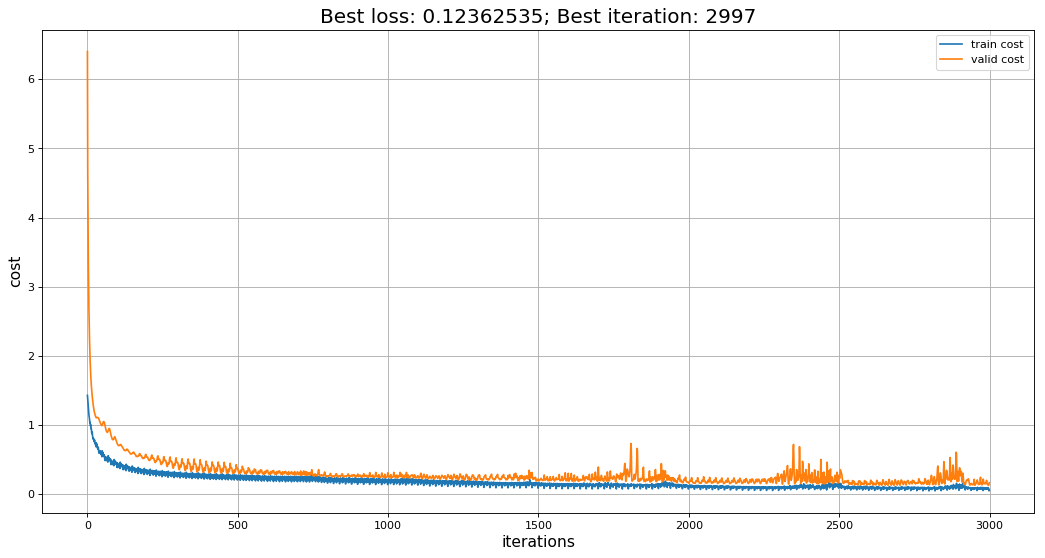

<Figure size 1800x1440 with 0 Axes>

In [26]:
plt.figure(figsize=(16, 8), dpi= 80, facecolor='w', edgecolor='k')
plt.plot(train_loss, label = 'train cost')
plt.plot(valid_loss, label = 'valid cost')
plt.xlabel('iterations', fontsize = 14)
plt.ylabel('cost', fontsize = 14)
plt.title("Best loss: "+str(best_loss)+"; Best iteration: "+str(best_iteration),fontsize = 18)
plt.legend()
plt.grid()
plt.show()
# figure path directory
figure_dir = "./model_cost_figures/"
# save the figure in the designated directory
plt.savefig(figure_dir + 'model.png', bbox_inches='tight')

## 5. Inspect and choose threshold for binirization of predicted masks

**Compute predicted masks for validation set**

In [27]:
with tf.Session() as sess:
    # restore the best model
    model_path = model_dir+"my-model-"+str(best_iteration)
    saver.restore(sess, model_path)
    # compute the predicted mask of the validation set
    mask_predicted = sess.run(Y_, feed_dict=feed_dict_validation)

INFO:tensorflow:Restoring parameters from ./model_files/my-model-2997


### 5.1 A function to plot masks and corresponding predicted masks

In [28]:
def plot_masks_and_predicted_masks(mask_validation, mask_predicted, indices,treshold):
    
    '''
    A function to plot masks and corresponding predicted masks
    '''
    # squeeze arrays containing masks and predicted masks of validation set
    mask_predicted_squeezed = np.squeeze(mask_predicted[indices])
    mask_validation_squeezed = np.squeeze(mask_validation[indices].astype(np.float32))
    # binirize predicted masks
    mask_predicted_squeezed = binirize_mask(mask_predicted_squeezed, threshold = treshold)
    # print the threshold
    print("Threshold:", treshold)
    # plot the masks and corresponding predicted masks
    matplotlib.rcParams['figure.figsize'] = (25.0, 20.0)
    plt.subplot(4,4,1)
    plt.title("Original Mask")
    plt.imshow(mask_validation_squeezed[0])
    plt.subplot(4,4,1+4)
    plt.title("Predicted Mask")
    plt.imshow(mask_predicted_squeezed[0])
    plt.subplot(4,4,2)
    plt.title("Original Mask")
    plt.imshow(mask_validation_squeezed[1])
    plt.subplot(4,4,2+4)
    plt.title("Predicted Mask")
    plt.imshow(mask_predicted_squeezed[1].astype(np.uint8))
    plt.subplot(4,4,3)
    plt.title("Original Mask")
    plt.imshow(mask_validation_squeezed[2].astype(np.uint8))
    plt.subplot(4,4,3+4)
    plt.title("Predicted Mask")
    plt.imshow(mask_predicted_squeezed[2].astype(np.uint8))
    plt.subplot(4,4,4)
    plt.title("Original Mask")
    plt.imshow(mask_validation_squeezed[3].astype(np.uint8))
    plt.subplot(4,4,4+4)
    plt.title("Predicted Mask")
    plt.imshow(mask_predicted_squeezed[3].astype(np.uint8))
    plt.subplot(4,4,9)
    plt.title("Original Mask")
    plt.imshow(mask_validation_squeezed[4].astype(np.uint8))
    plt.subplot(4,4,1+12)
    plt.title("Predicted Mask")
    plt.imshow(mask_predicted_squeezed[4].astype(np.uint8))
    plt.subplot(4,4,10)
    plt.title("Original Mask")
    plt.imshow(mask_validation_squeezed[5].astype(np.uint8))
    plt.subplot(4,4,2+12)
    plt.title("Predicted Mask")
    plt.imshow(mask_predicted_squeezed[5].astype(np.uint8))
    plt.subplot(4,4,11)
    plt.title("Original Mask")
    plt.imshow(mask_validation_squeezed[6].astype(np.uint8))
    plt.subplot(4,4,3+12)
    plt.title("Predicted Mask")
    plt.imshow(mask_predicted_squeezed[6].astype(np.uint8))
    plt.subplot(4,4,12)
    plt.title("Original Mask")
    plt.imshow(mask_validation_squeezed[7].astype(np.uint8))
    plt.subplot(4,4,4+12)
    plt.title("Predicted Mask")
    plt.imshow(mask_predicted_squeezed[7].astype(np.uint8))
    plt.show()

### 5.2 Set indices of the validatation set and plot masks and corresponding predicted masks

Threshold: 0.01


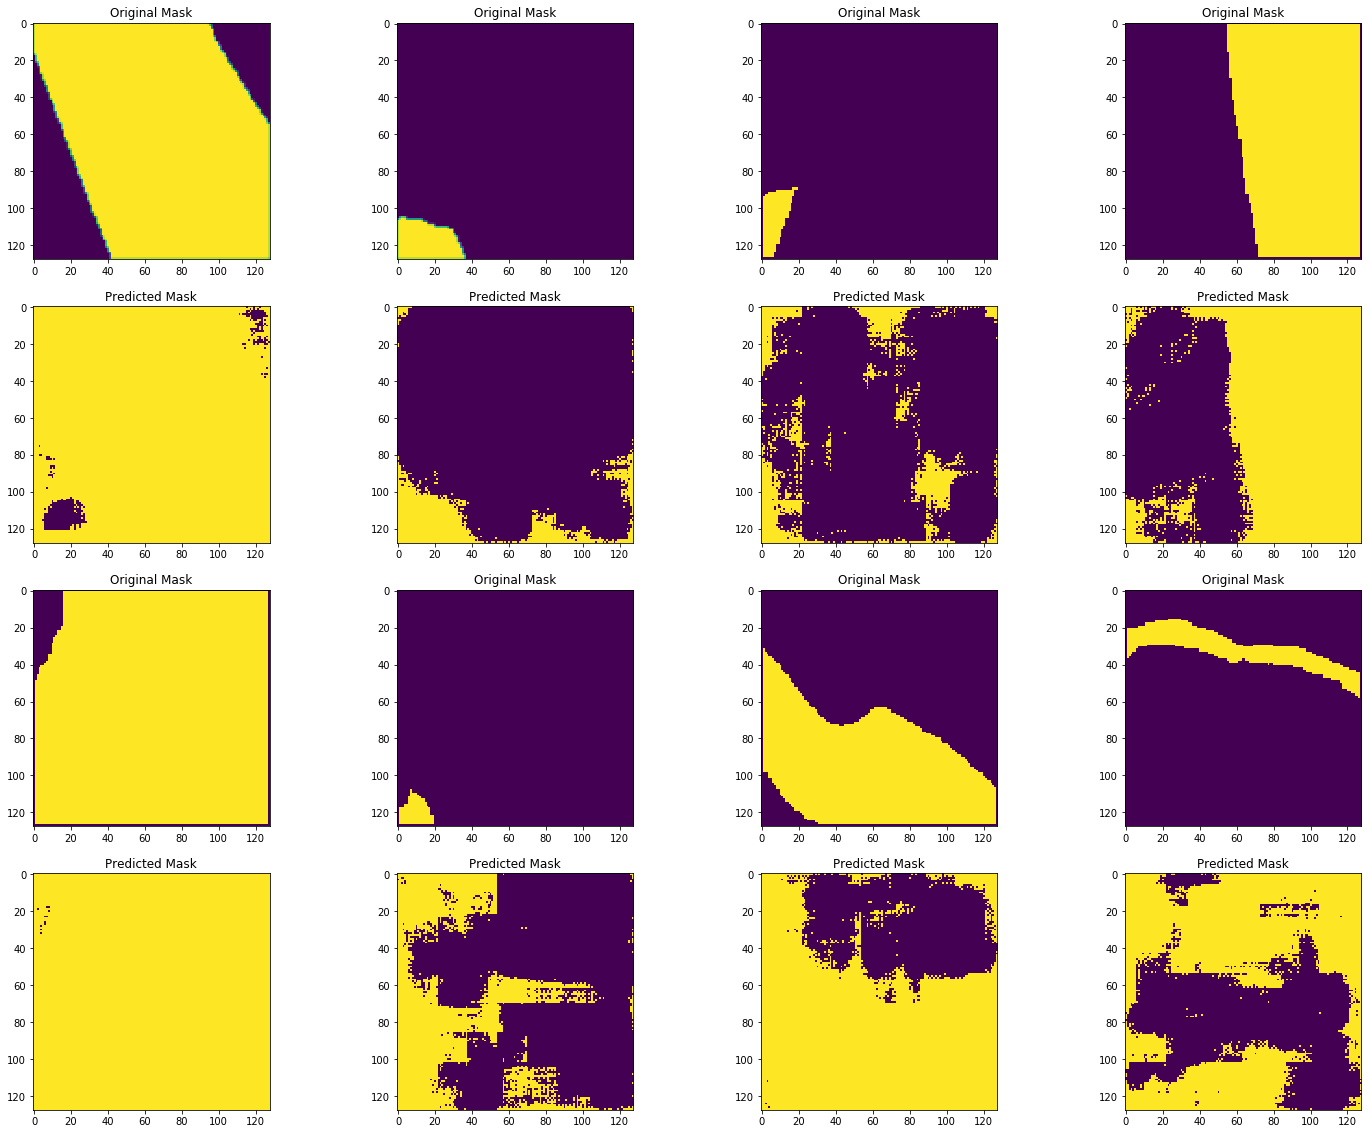

Threshold: 0.05


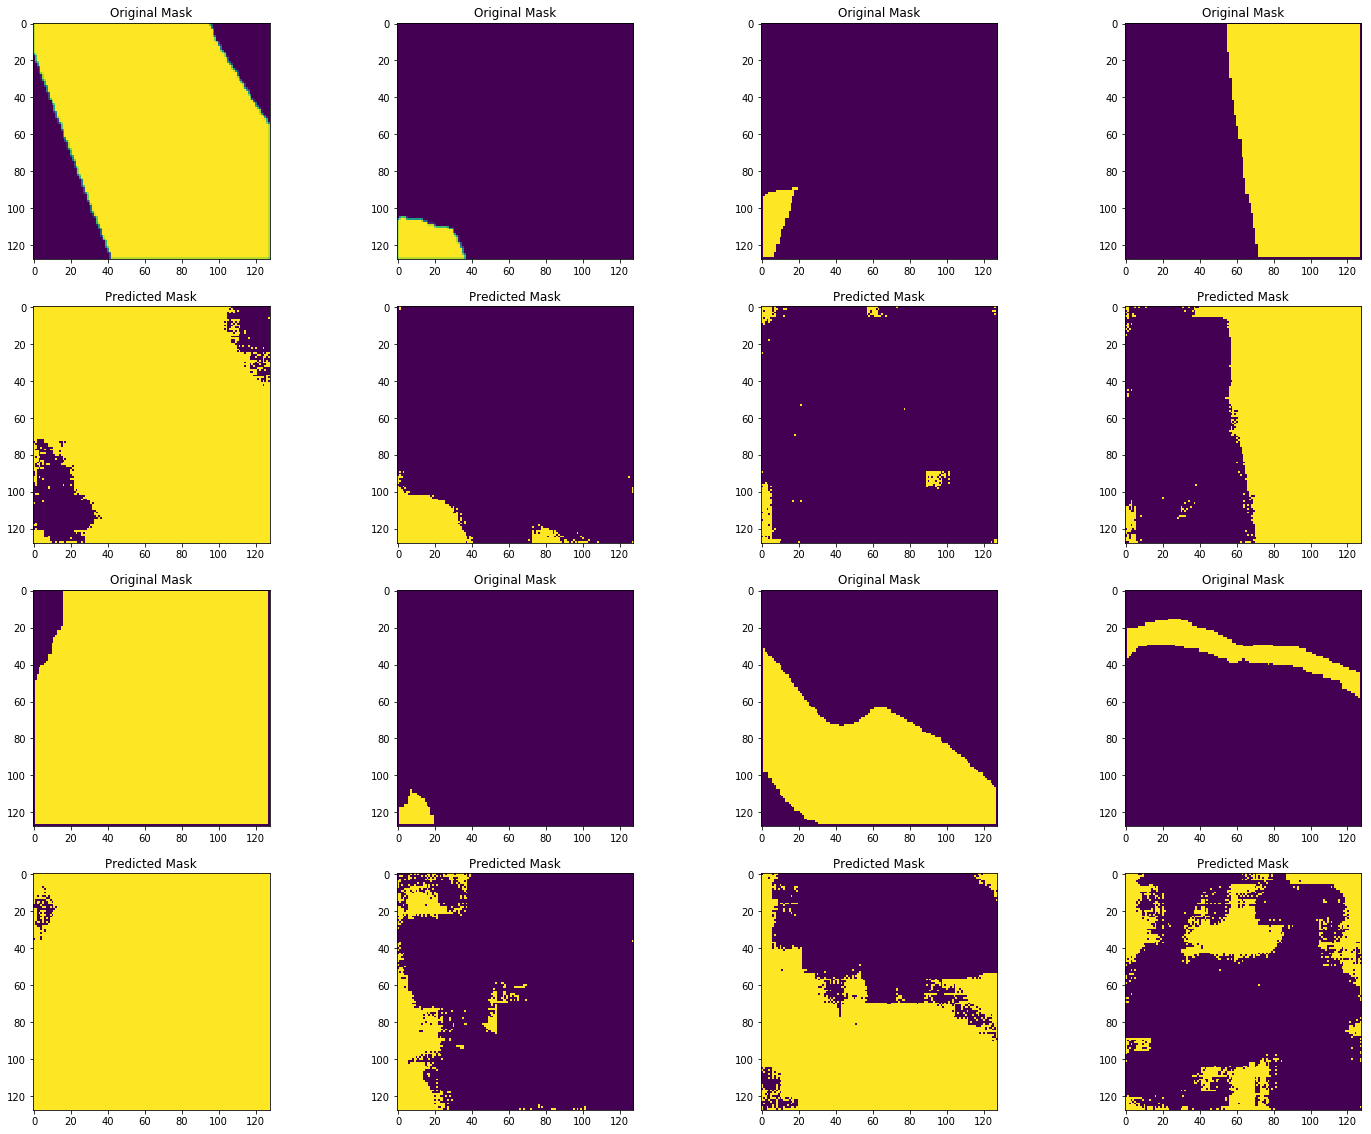

Threshold: 0.1


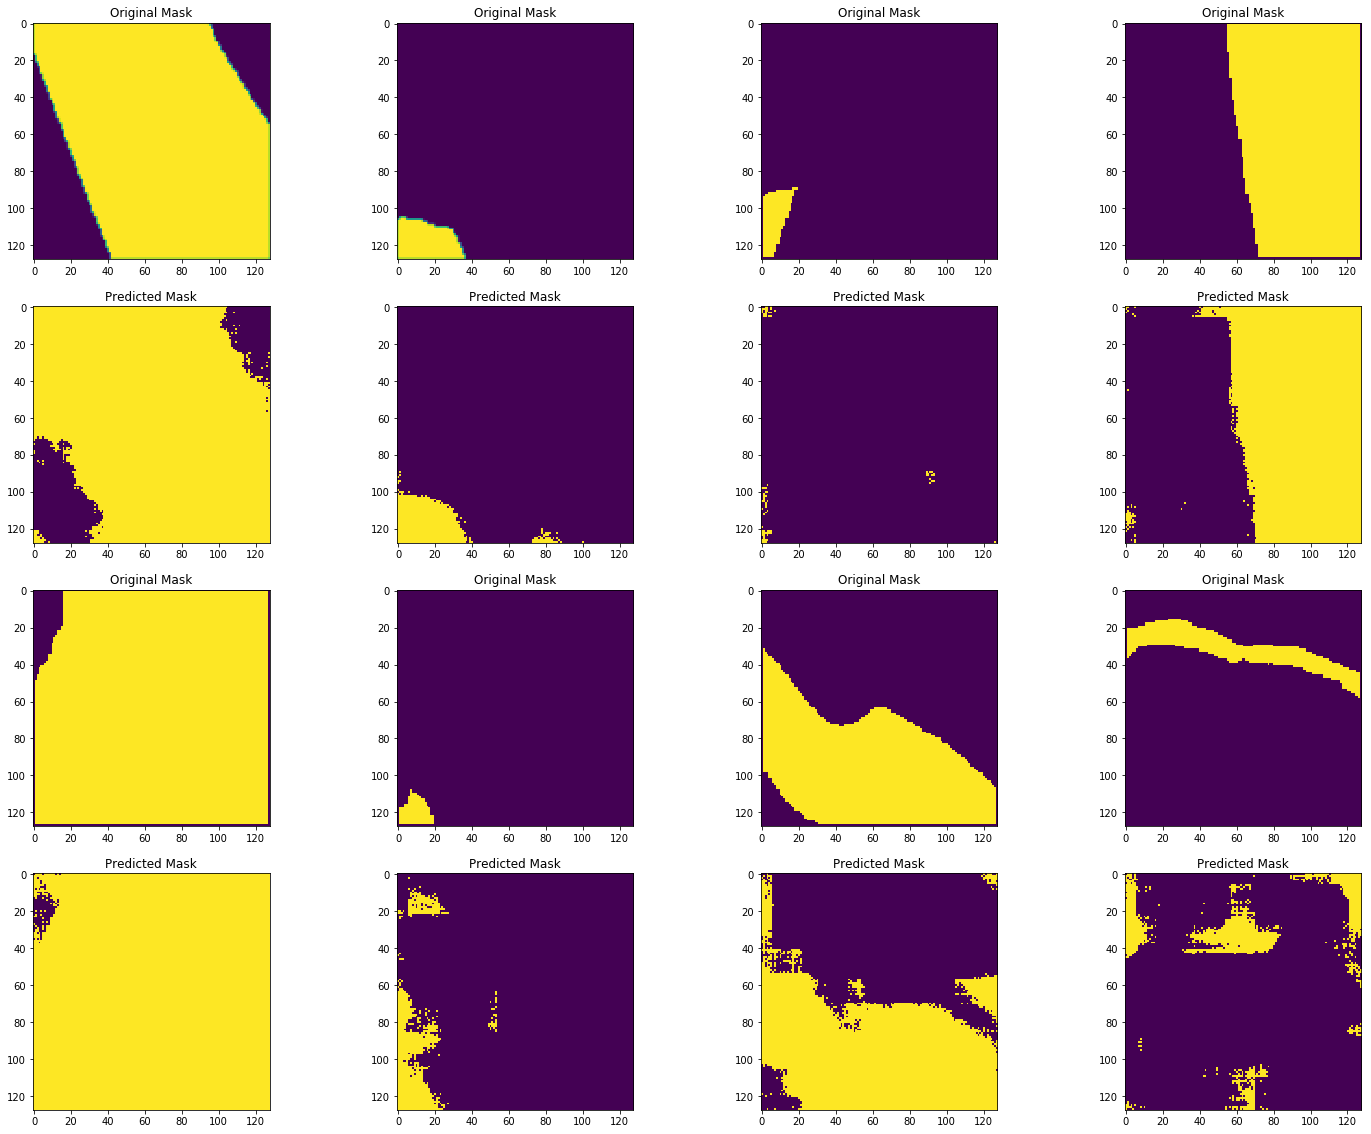

Threshold: 0.3


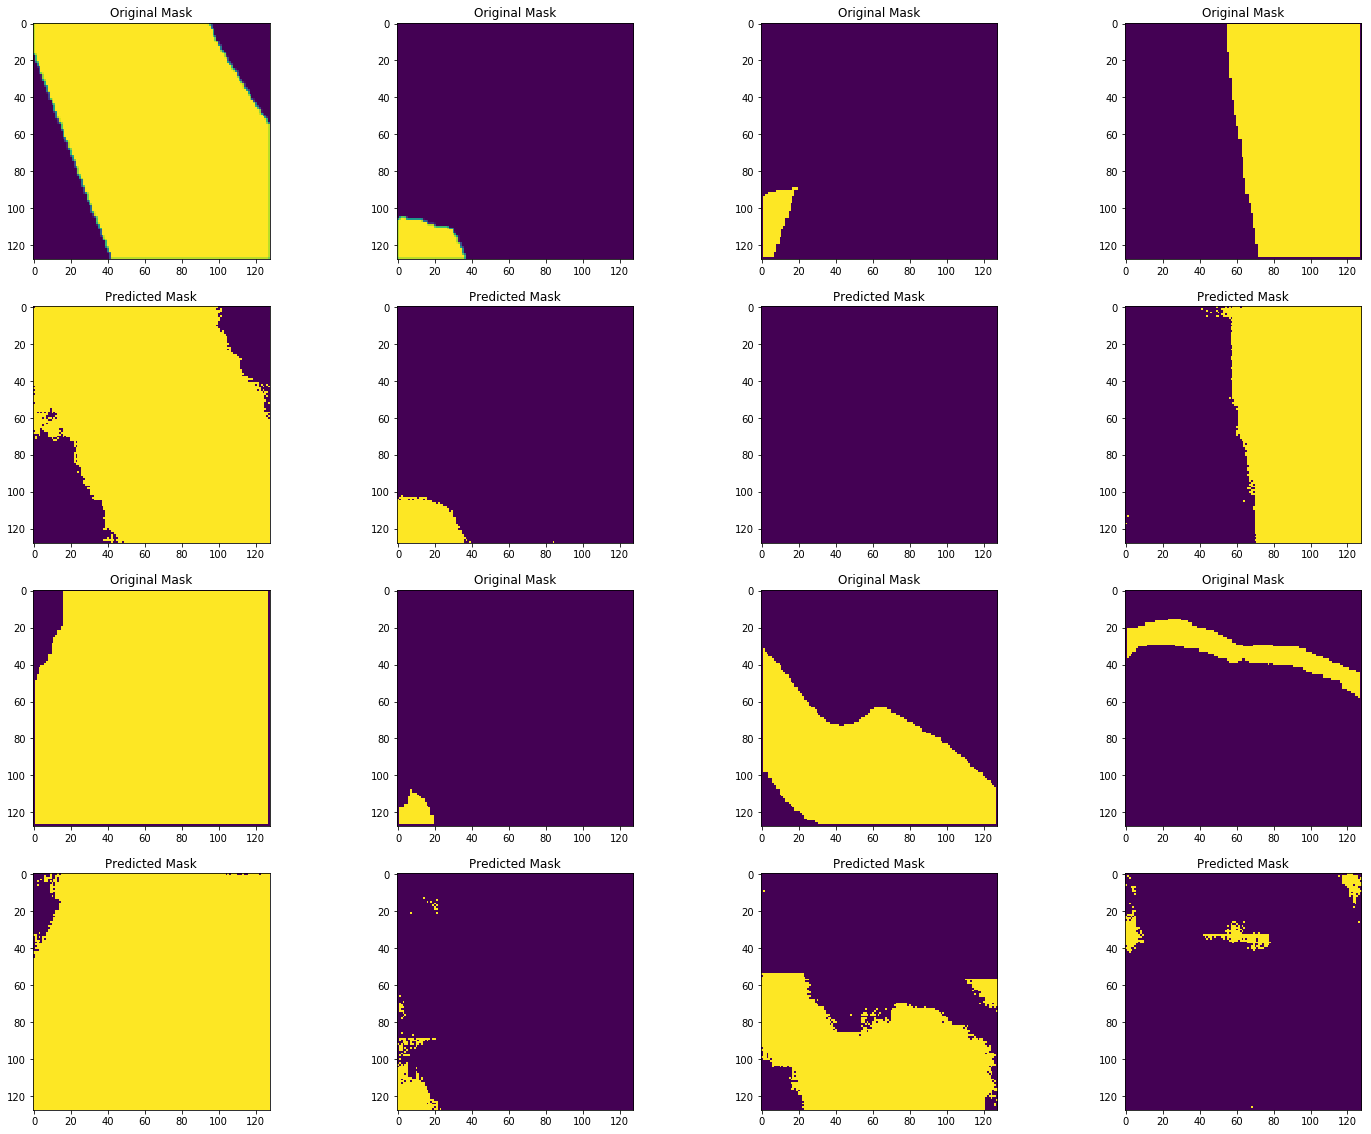

Threshold: 0.4


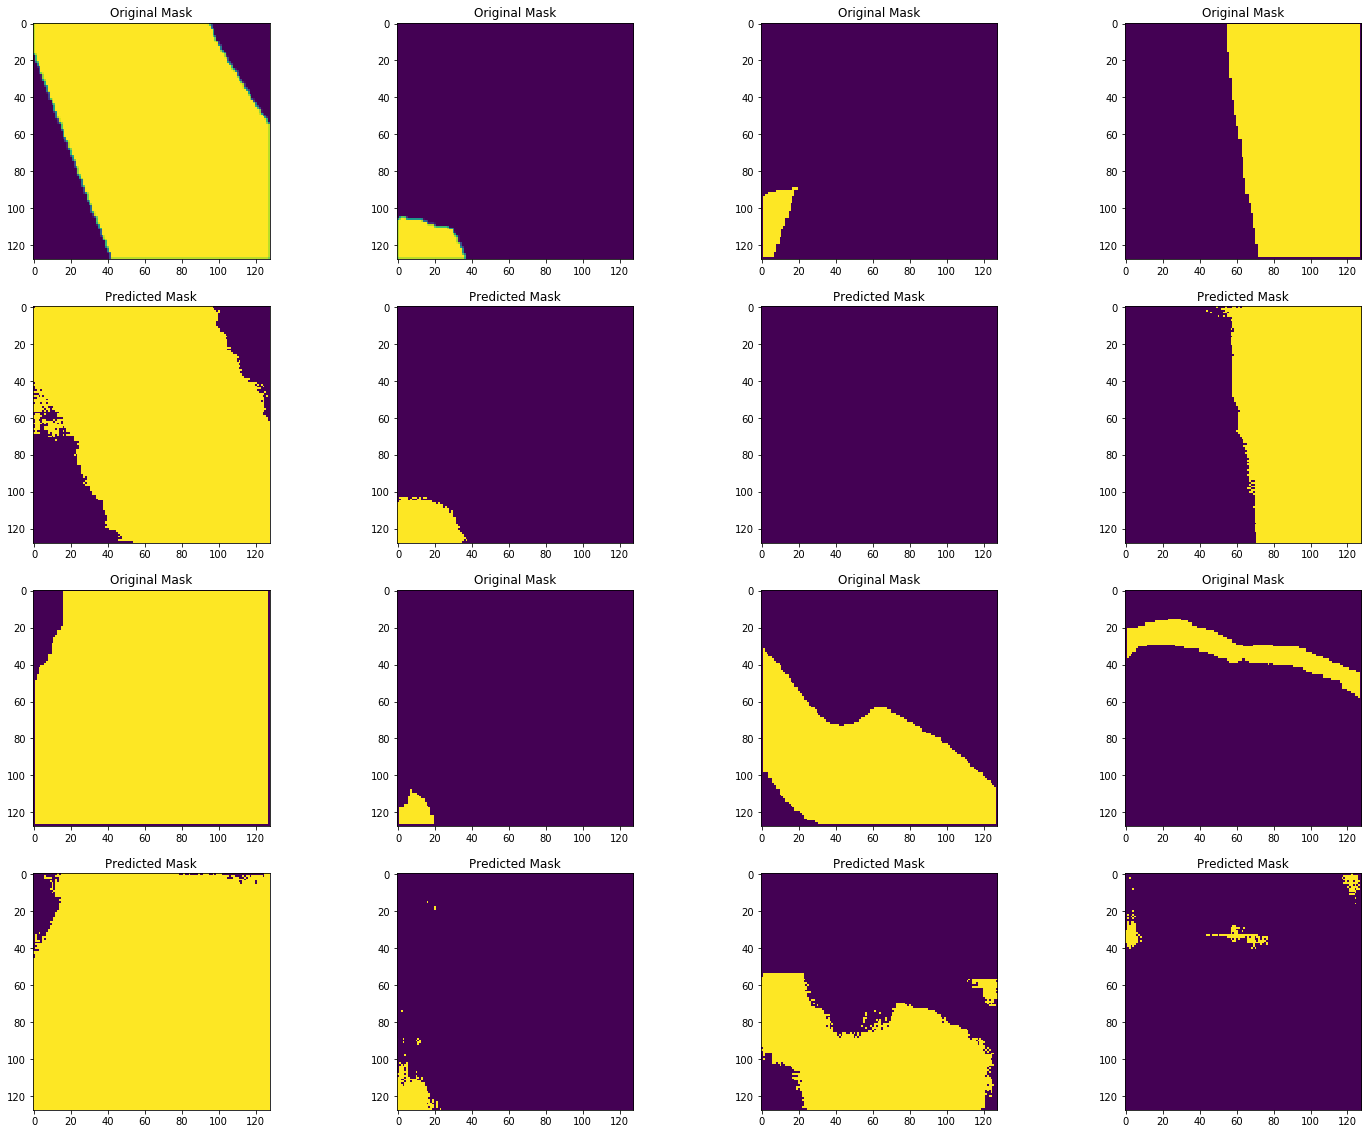

Threshold: 0.5


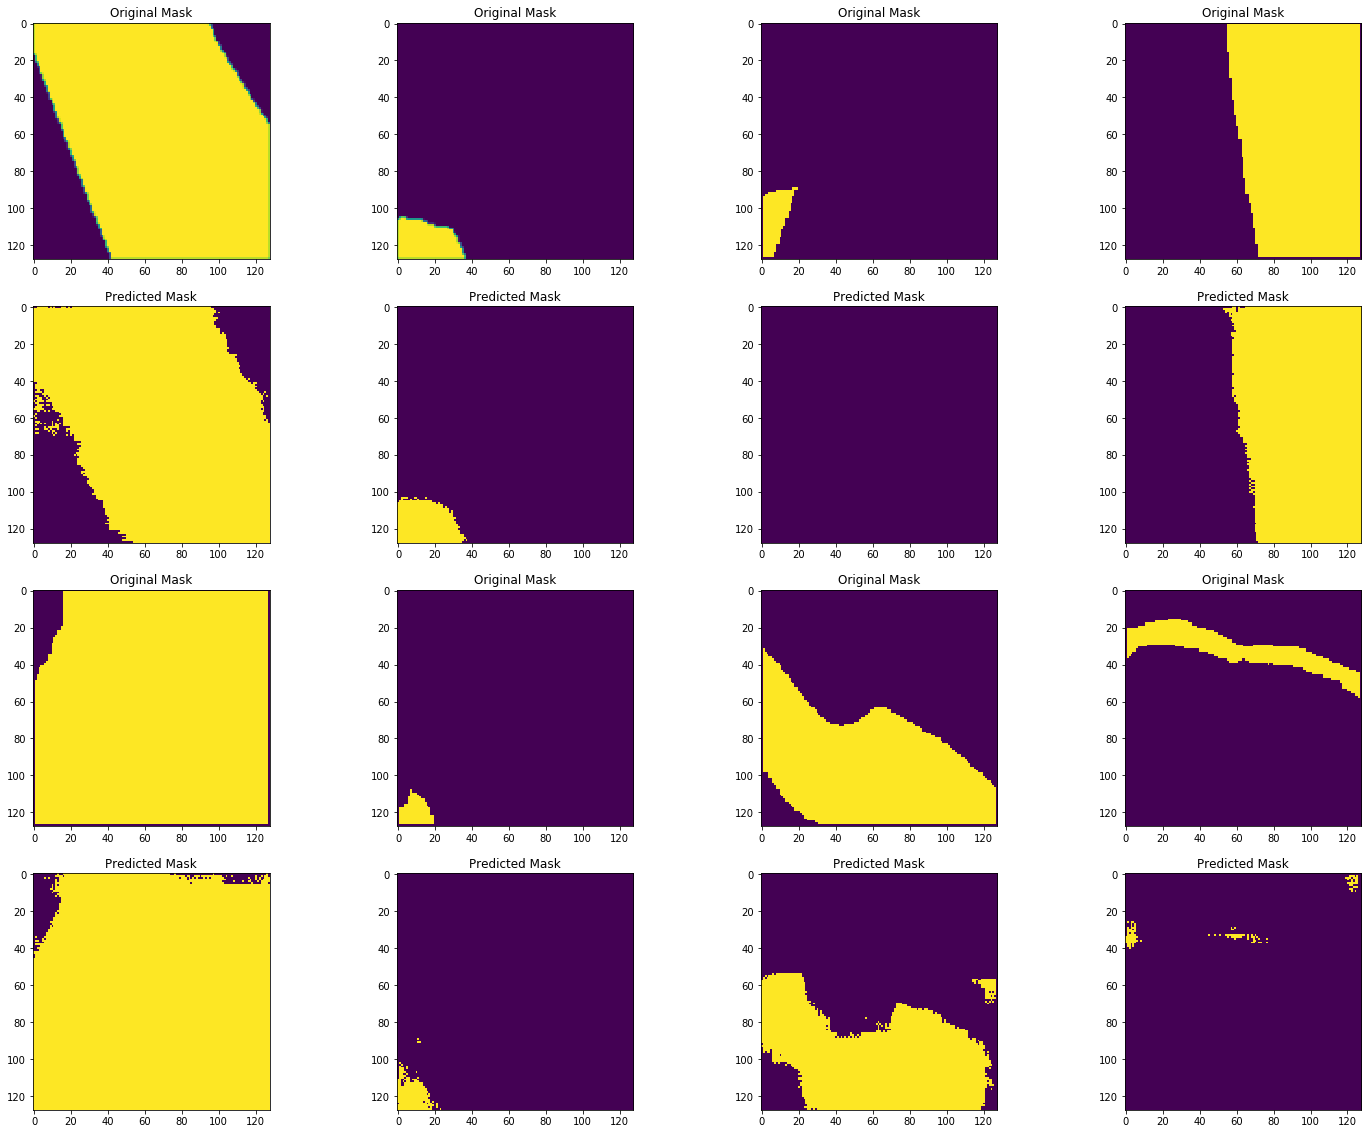

Threshold: 0.6


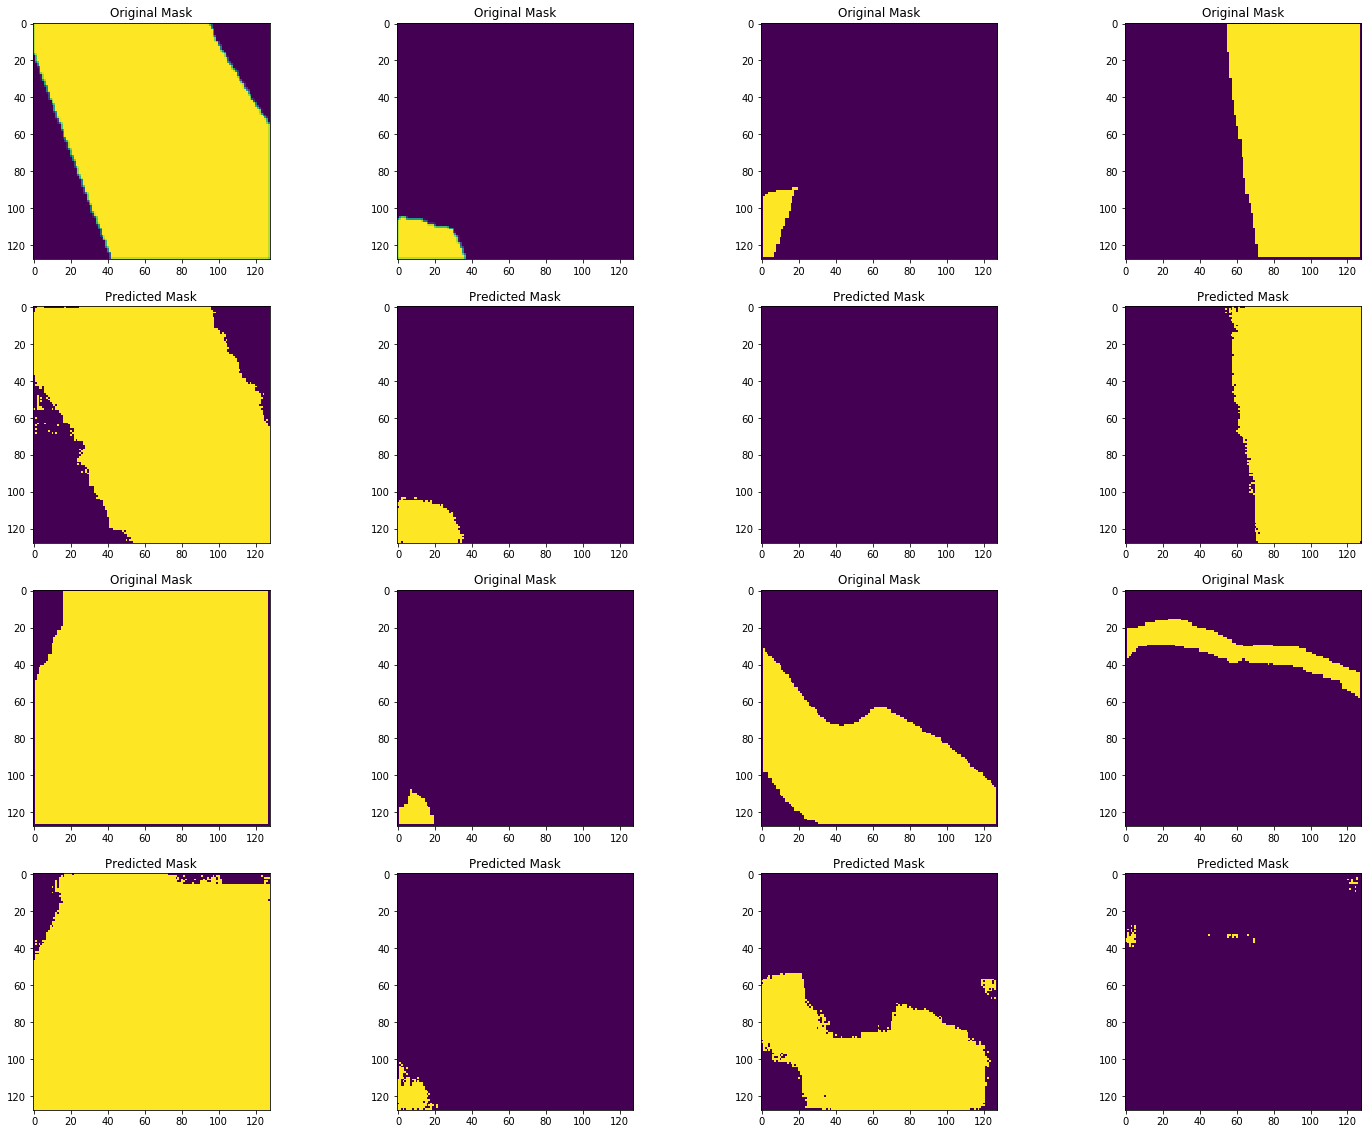

In [29]:
indices = np.array(list(range(0,8)))
plot_masks_and_predicted_masks(mask_validation, mask_predicted, indices, 0.01)
plot_masks_and_predicted_masks(mask_validation, mask_predicted, indices, 0.05)
plot_masks_and_predicted_masks(mask_validation, mask_predicted, indices, 0.1)
plot_masks_and_predicted_masks(mask_validation, mask_predicted, indices, 0.3)
plot_masks_and_predicted_masks(mask_validation, mask_predicted, indices, 0.4)
plot_masks_and_predicted_masks(mask_validation, mask_predicted, indices, 0.5)
plot_masks_and_predicted_masks(mask_validation, mask_predicted, indices, 0.6)

Threshold: 0.01


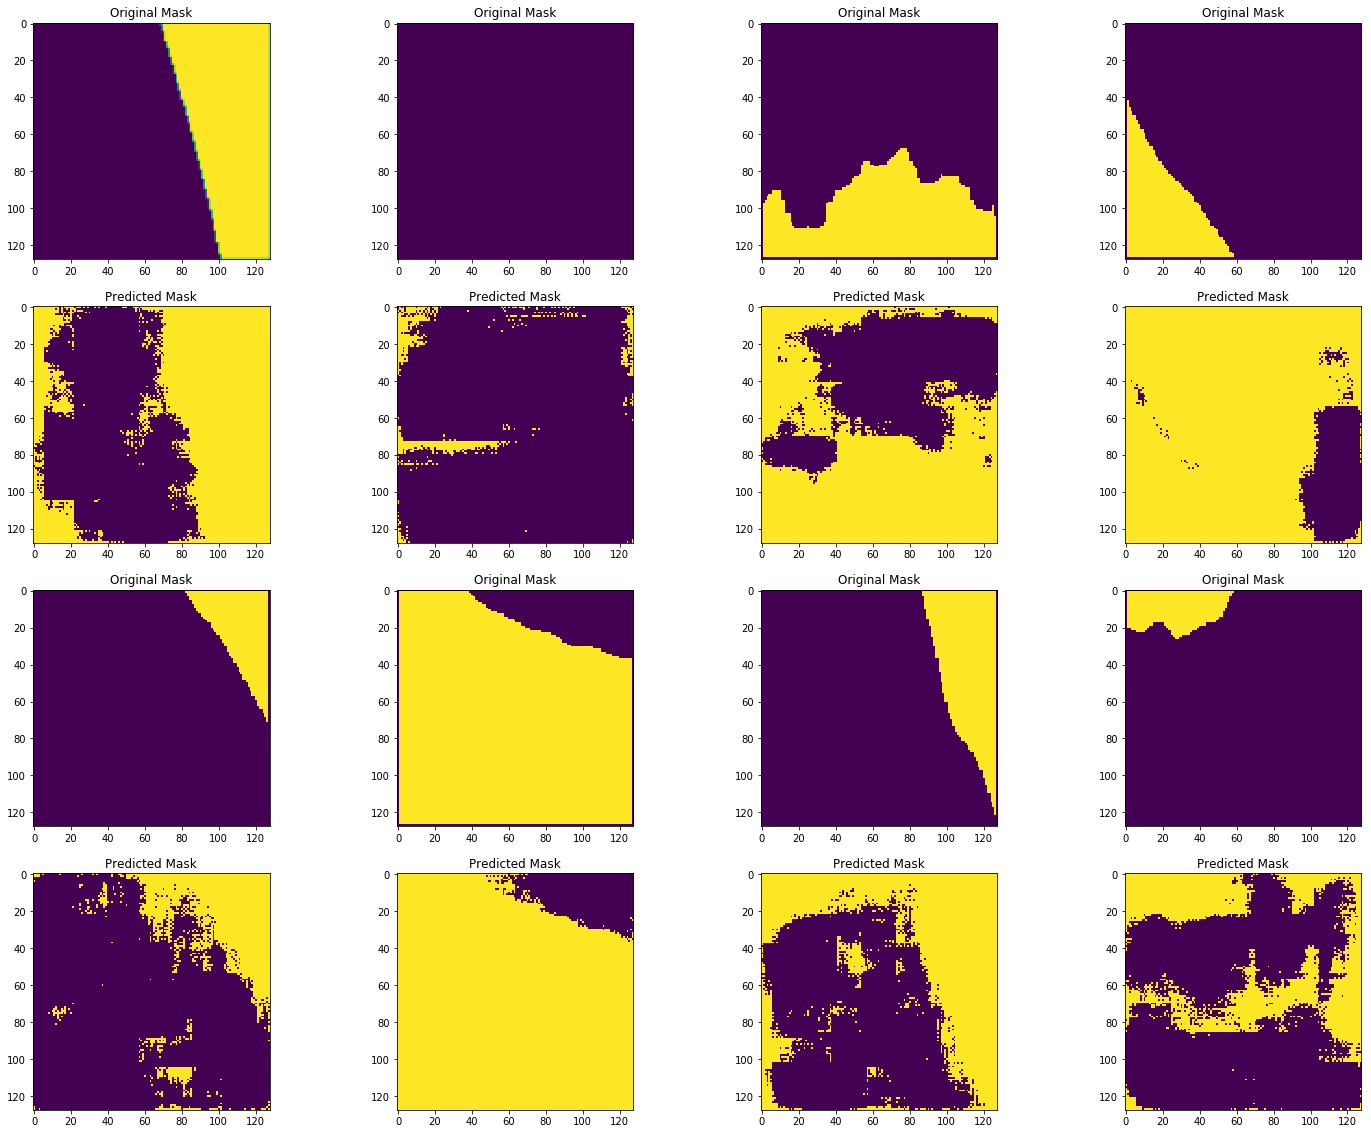

Threshold: 0.05


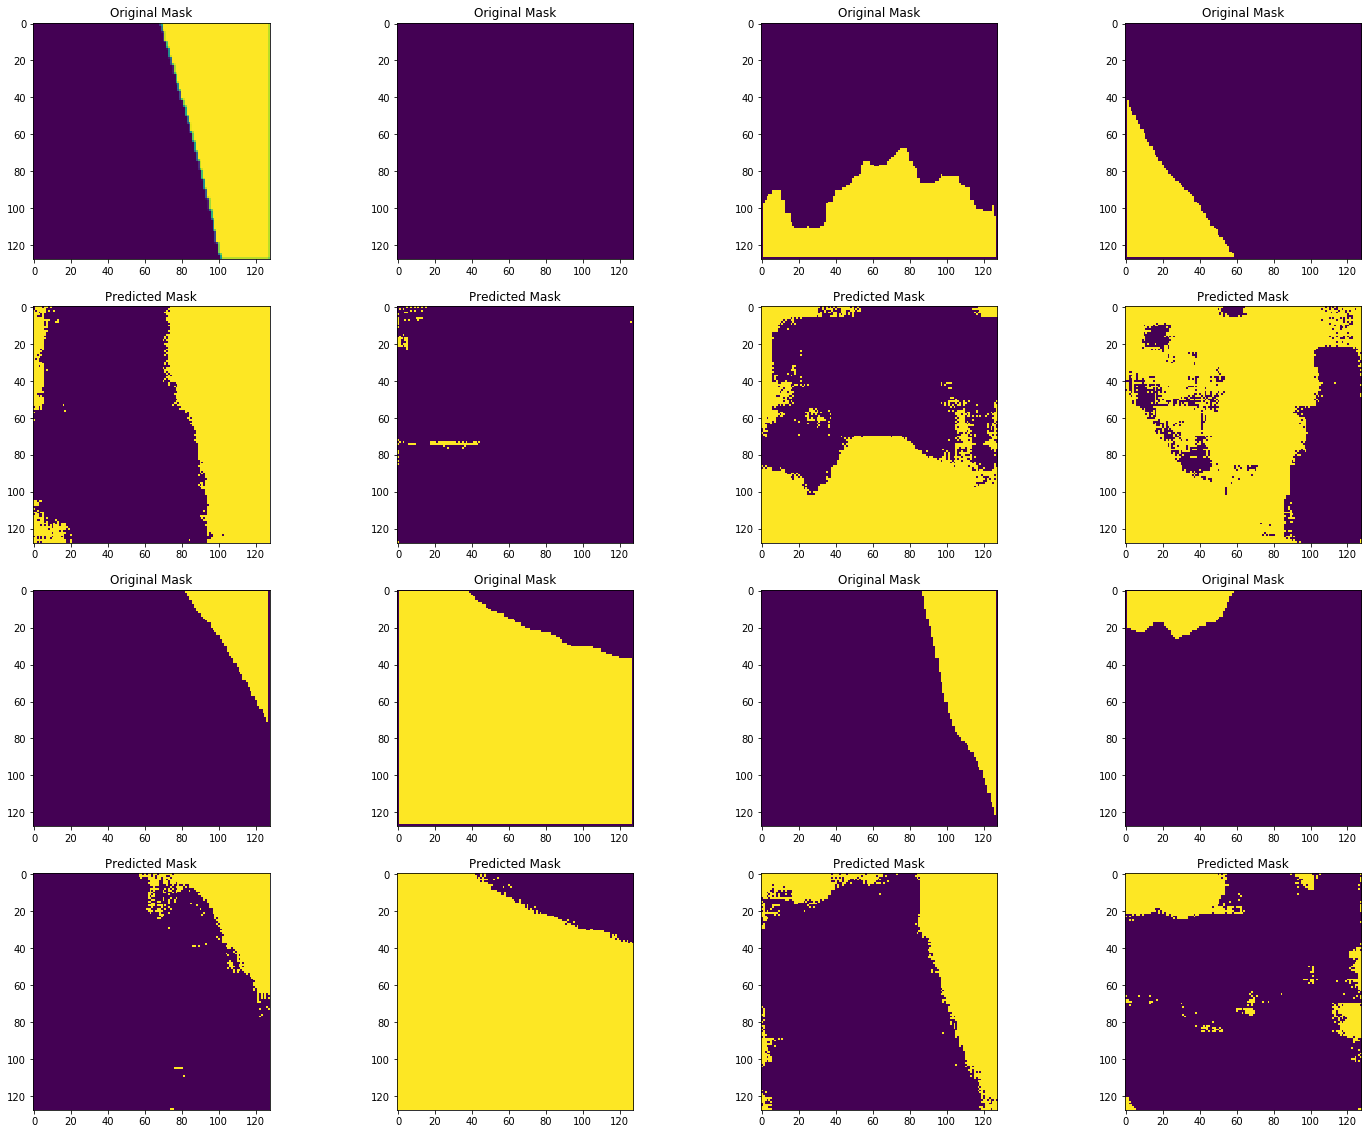

Threshold: 0.1


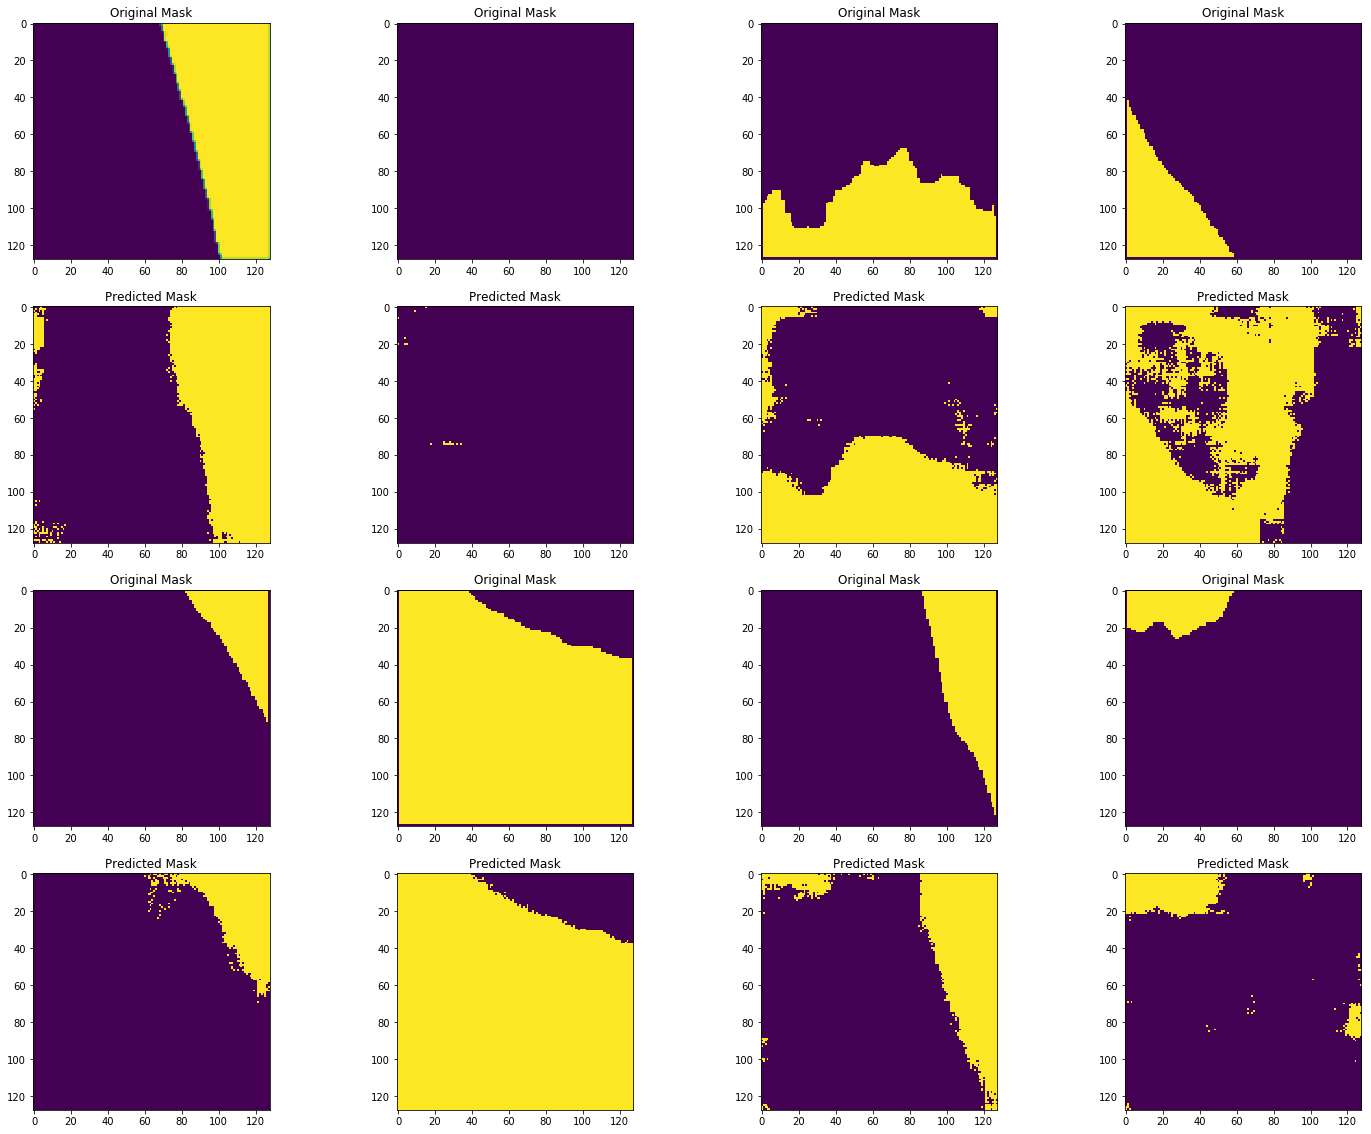

Threshold: 0.3


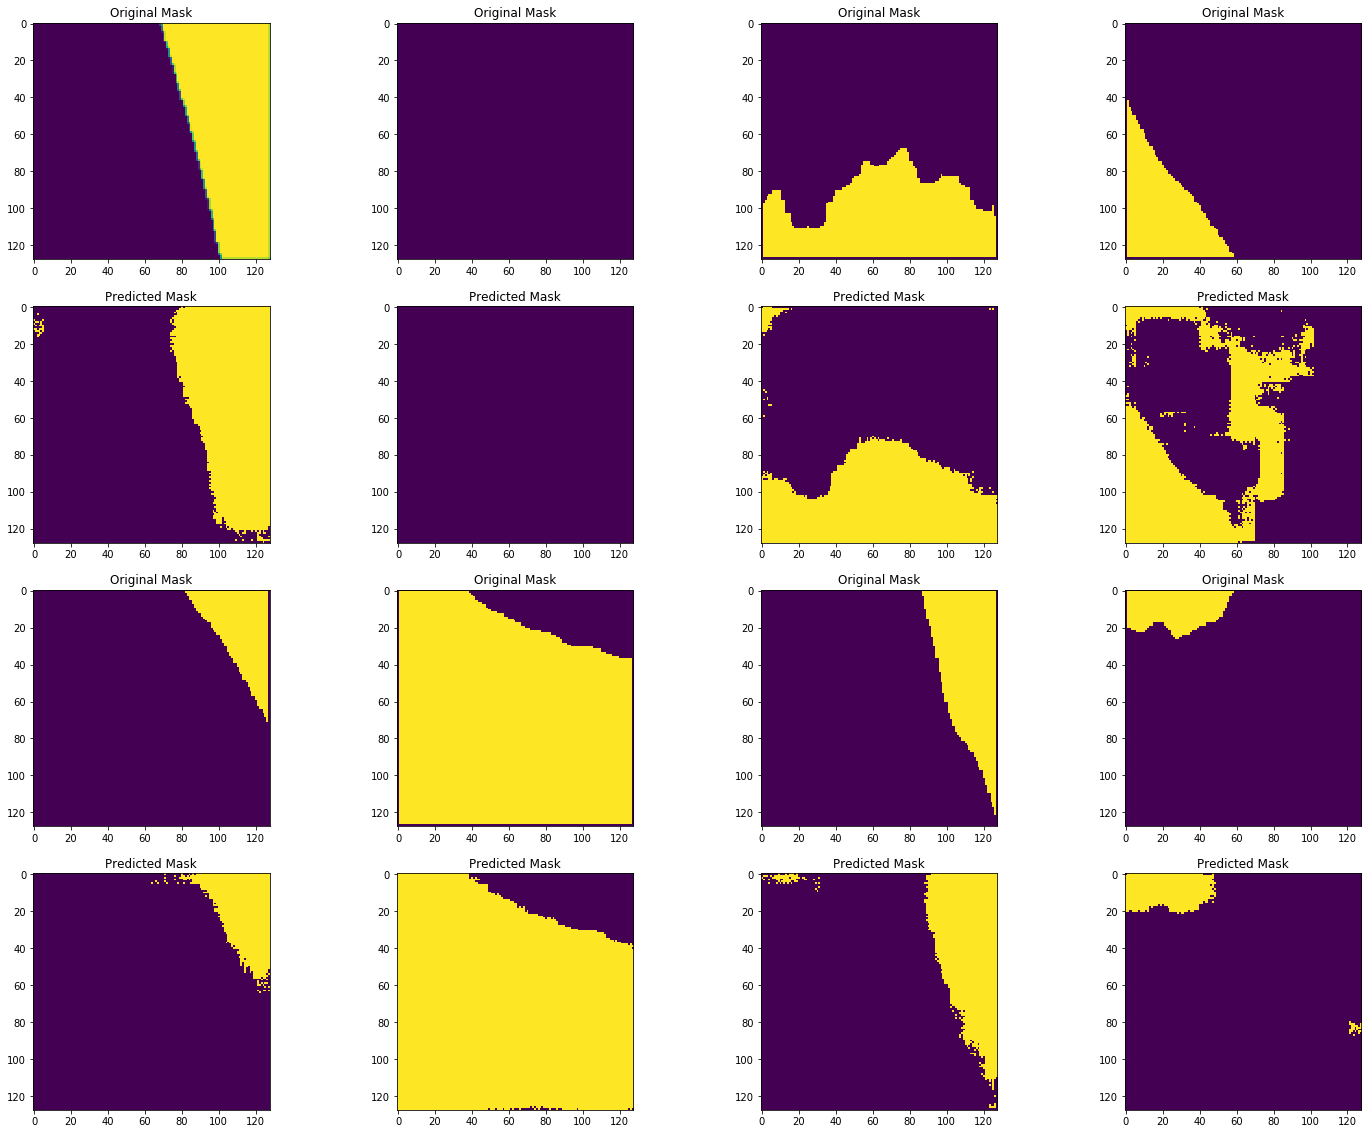

Threshold: 0.4


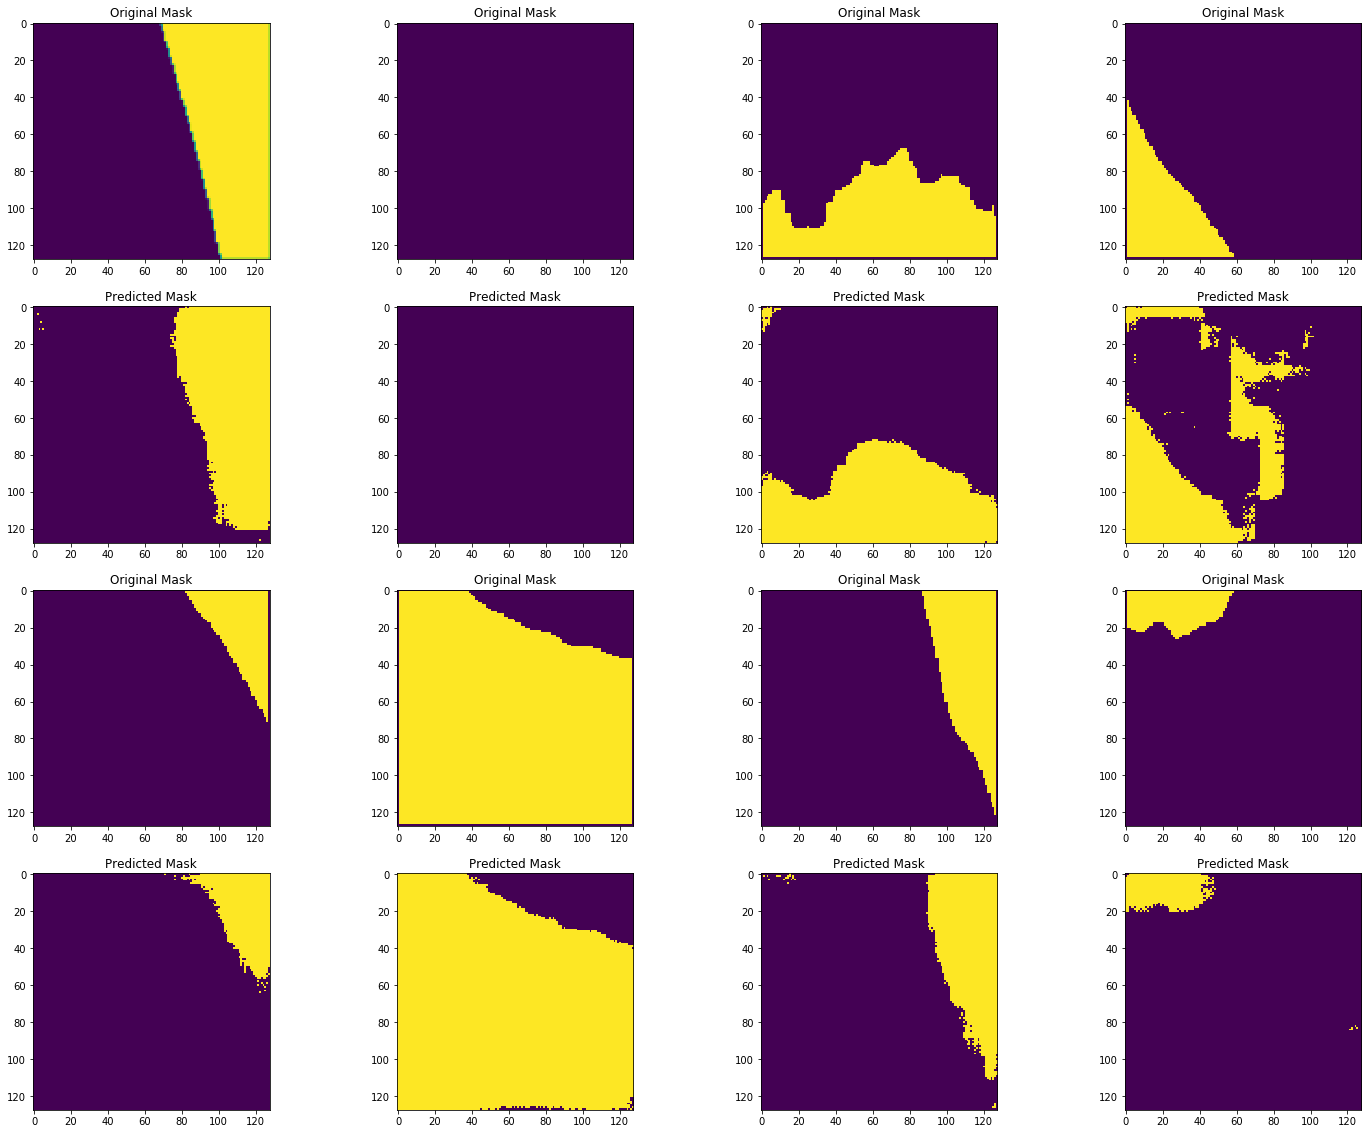

Threshold: 0.5


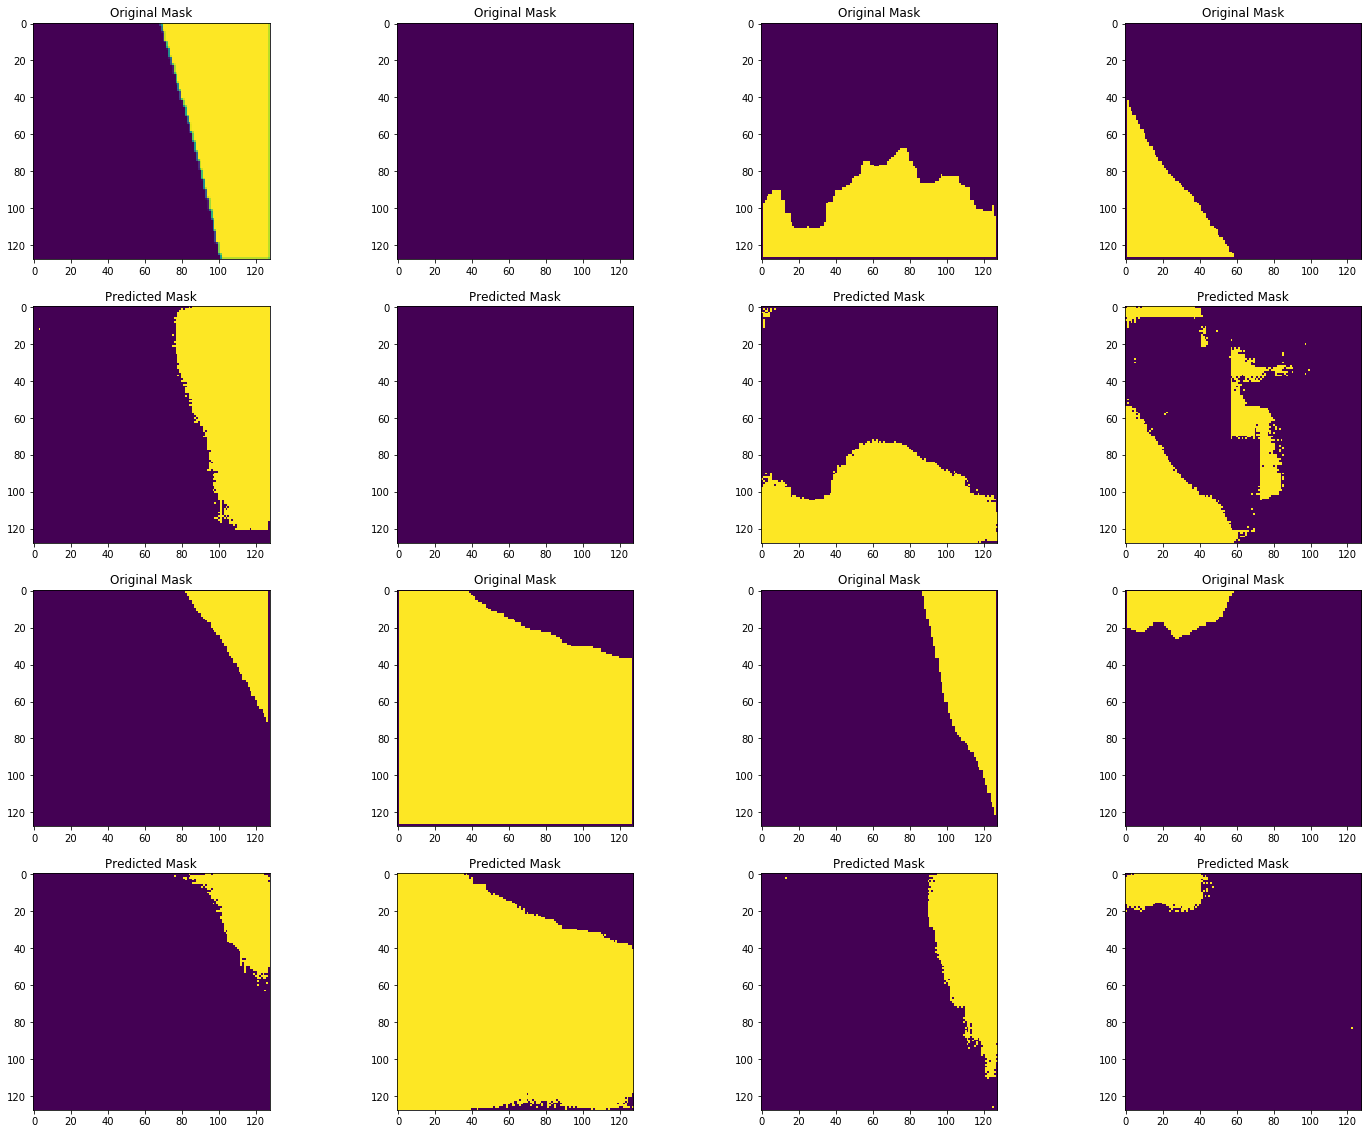

Threshold: 0.6


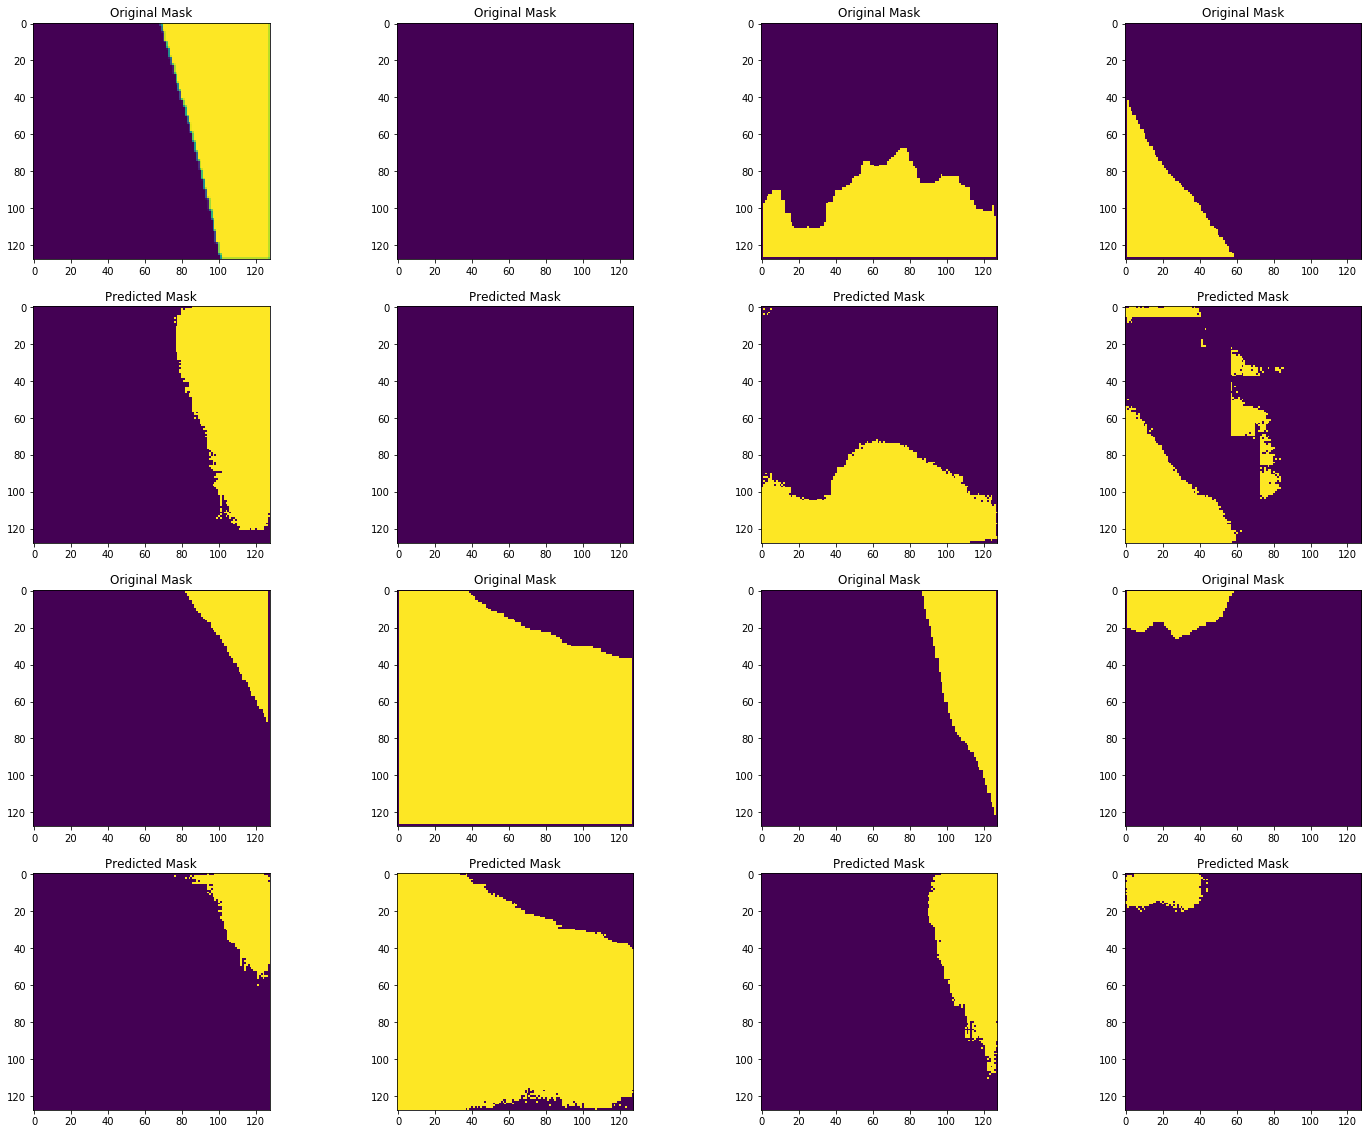

In [30]:
indices = np.array(list(range(8,16)))
plot_masks_and_predicted_masks(mask_validation, mask_predicted, indices, 0.01)
plot_masks_and_predicted_masks(mask_validation, mask_predicted, indices, 0.05)
plot_masks_and_predicted_masks(mask_validation, mask_predicted, indices, 0.1)
plot_masks_and_predicted_masks(mask_validation, mask_predicted, indices, 0.3)
plot_masks_and_predicted_masks(mask_validation, mask_predicted, indices, 0.4)
plot_masks_and_predicted_masks(mask_validation, mask_predicted, indices, 0.5)
plot_masks_and_predicted_masks(mask_validation, mask_predicted, indices, 0.6)

Threshold: 0.01


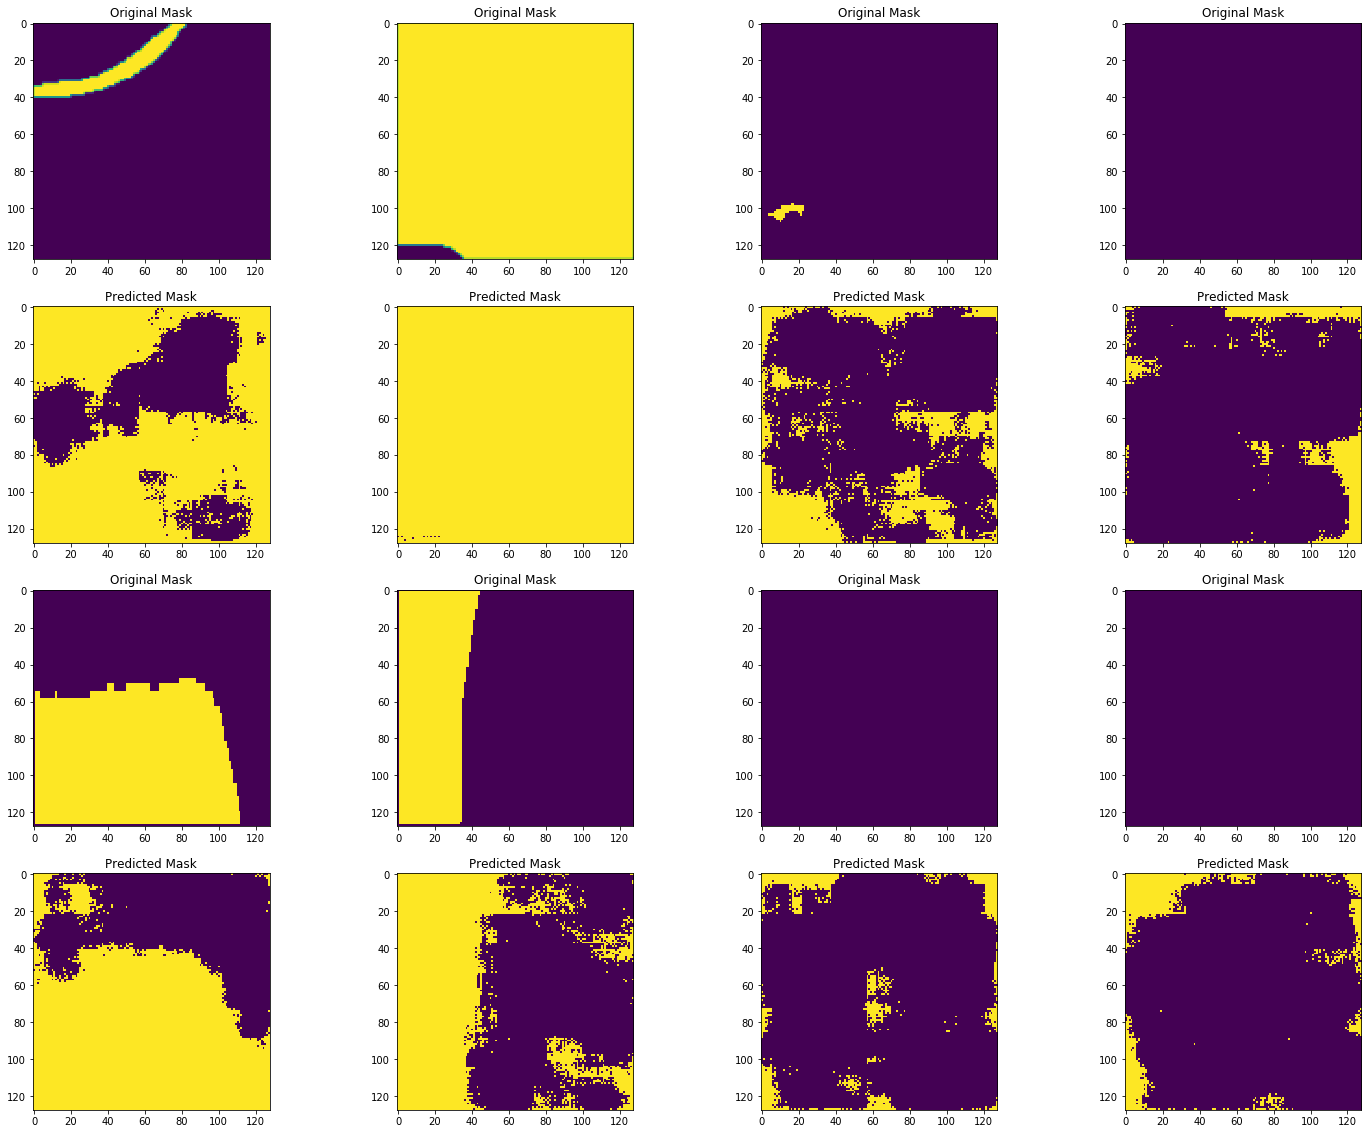

Threshold: 0.05


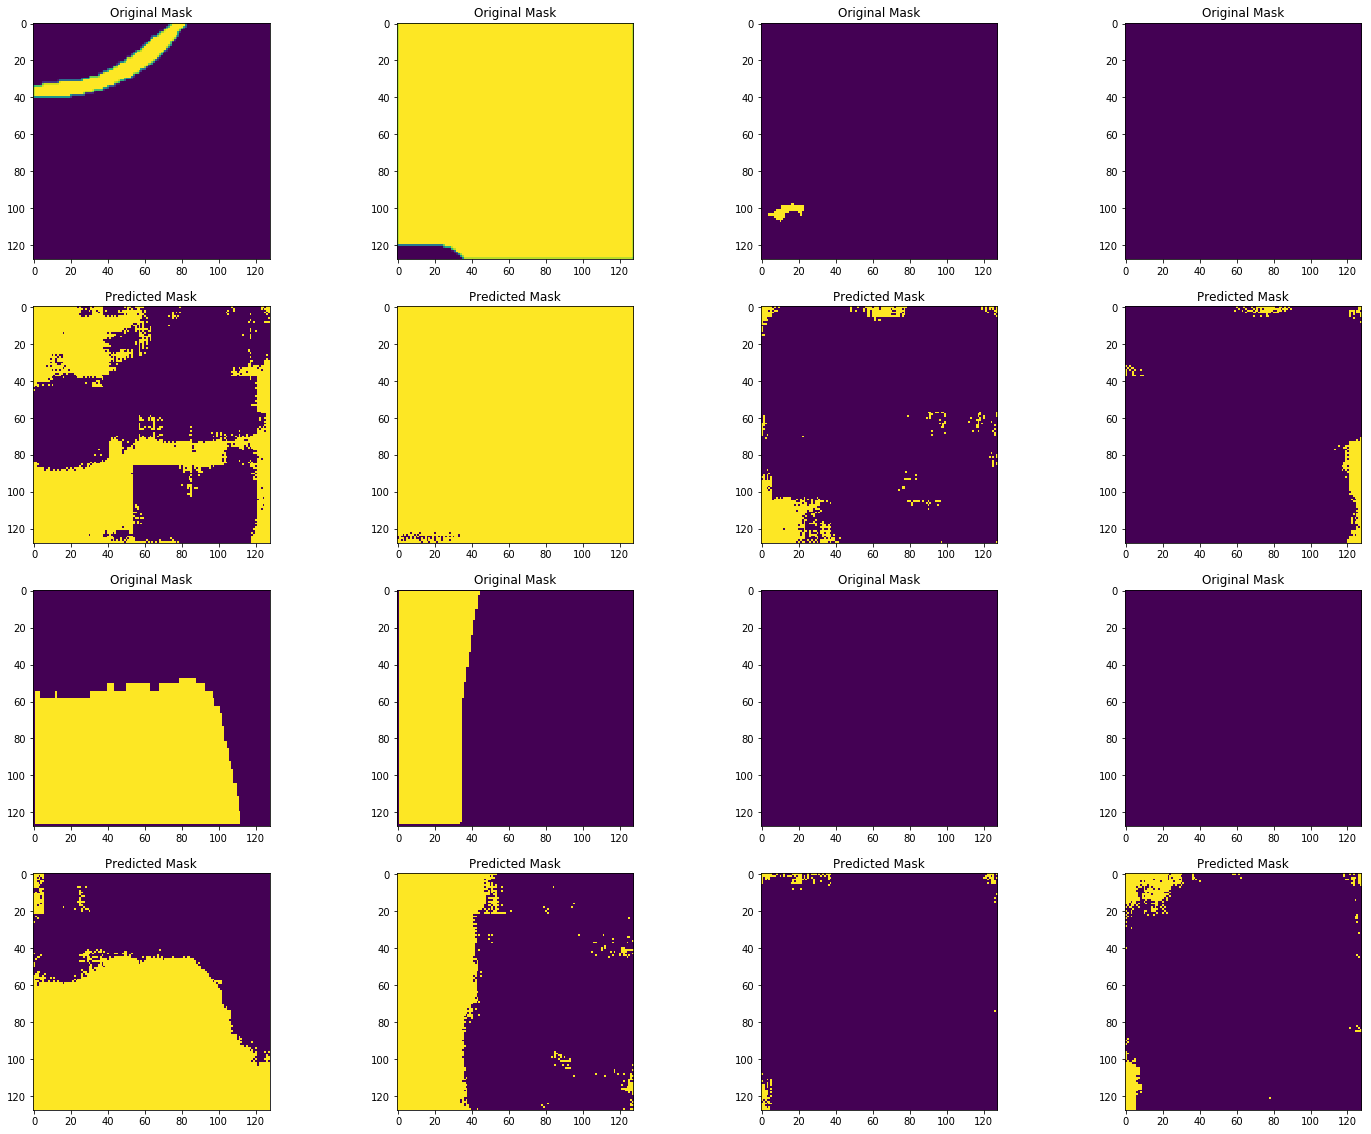

Threshold: 0.1


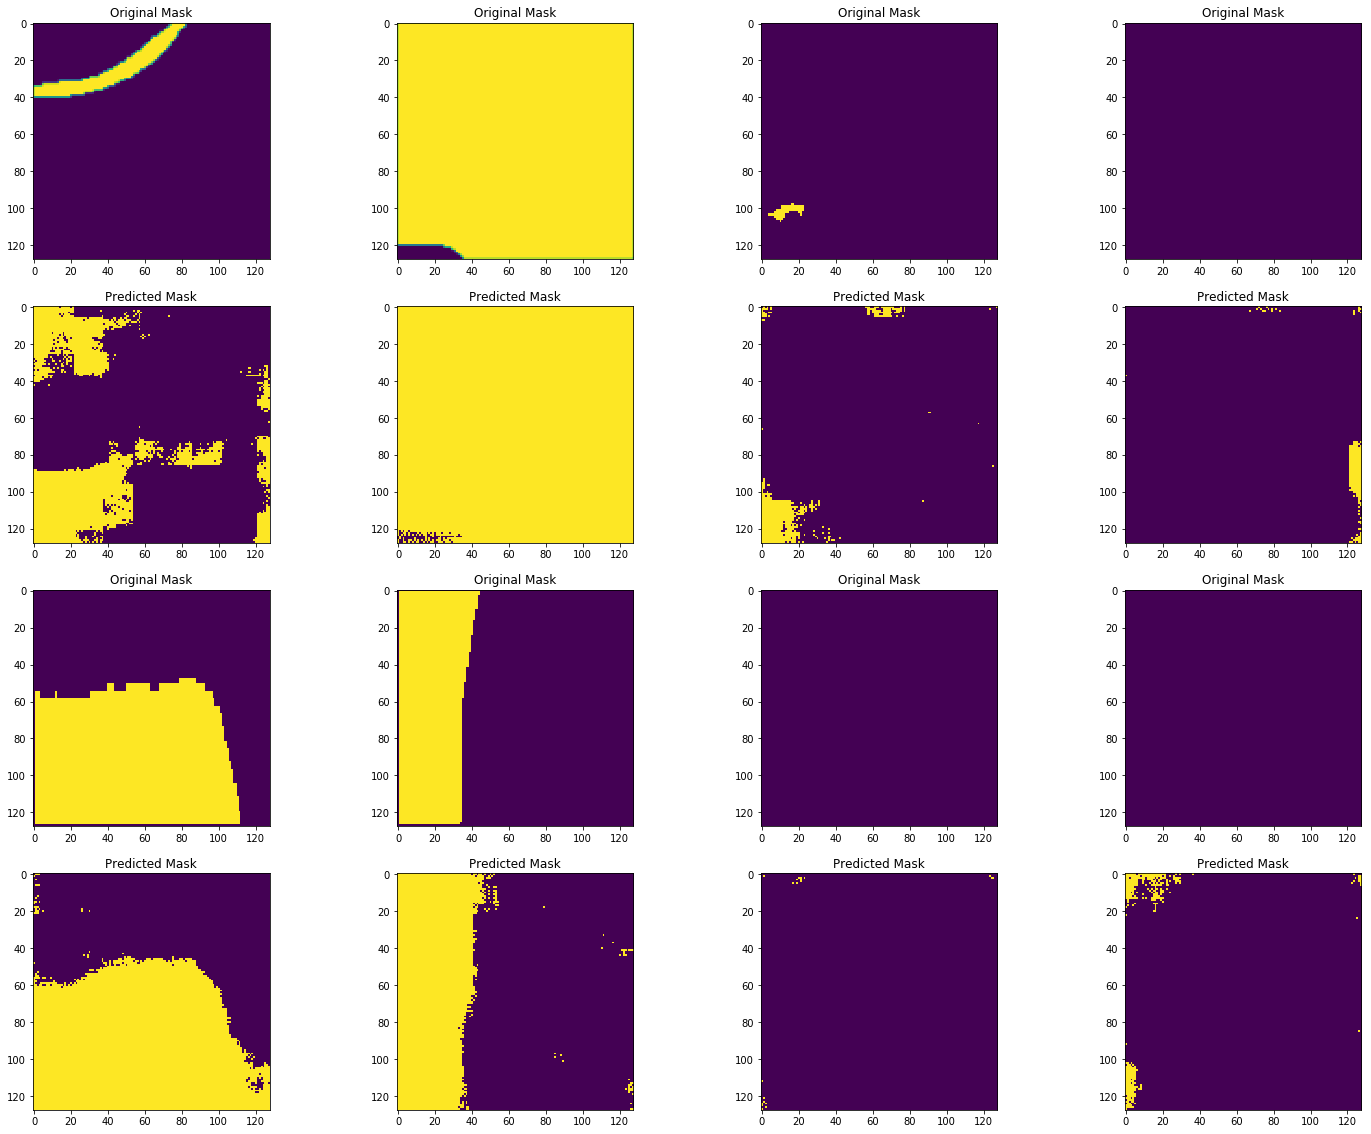

Threshold: 0.3


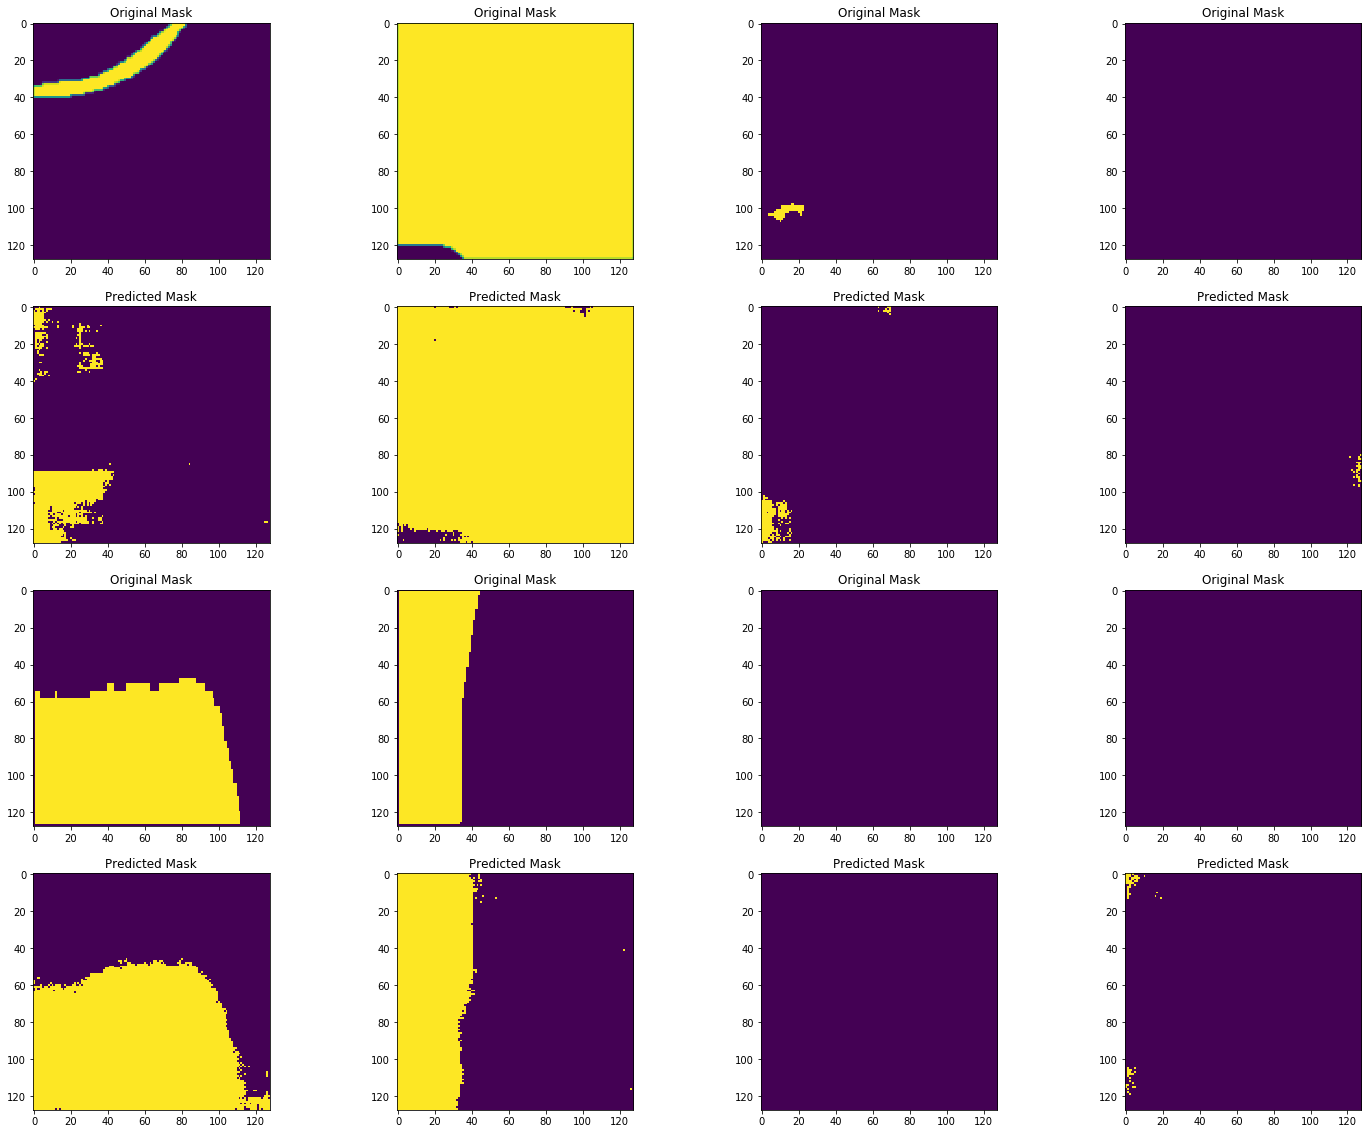

Threshold: 0.4


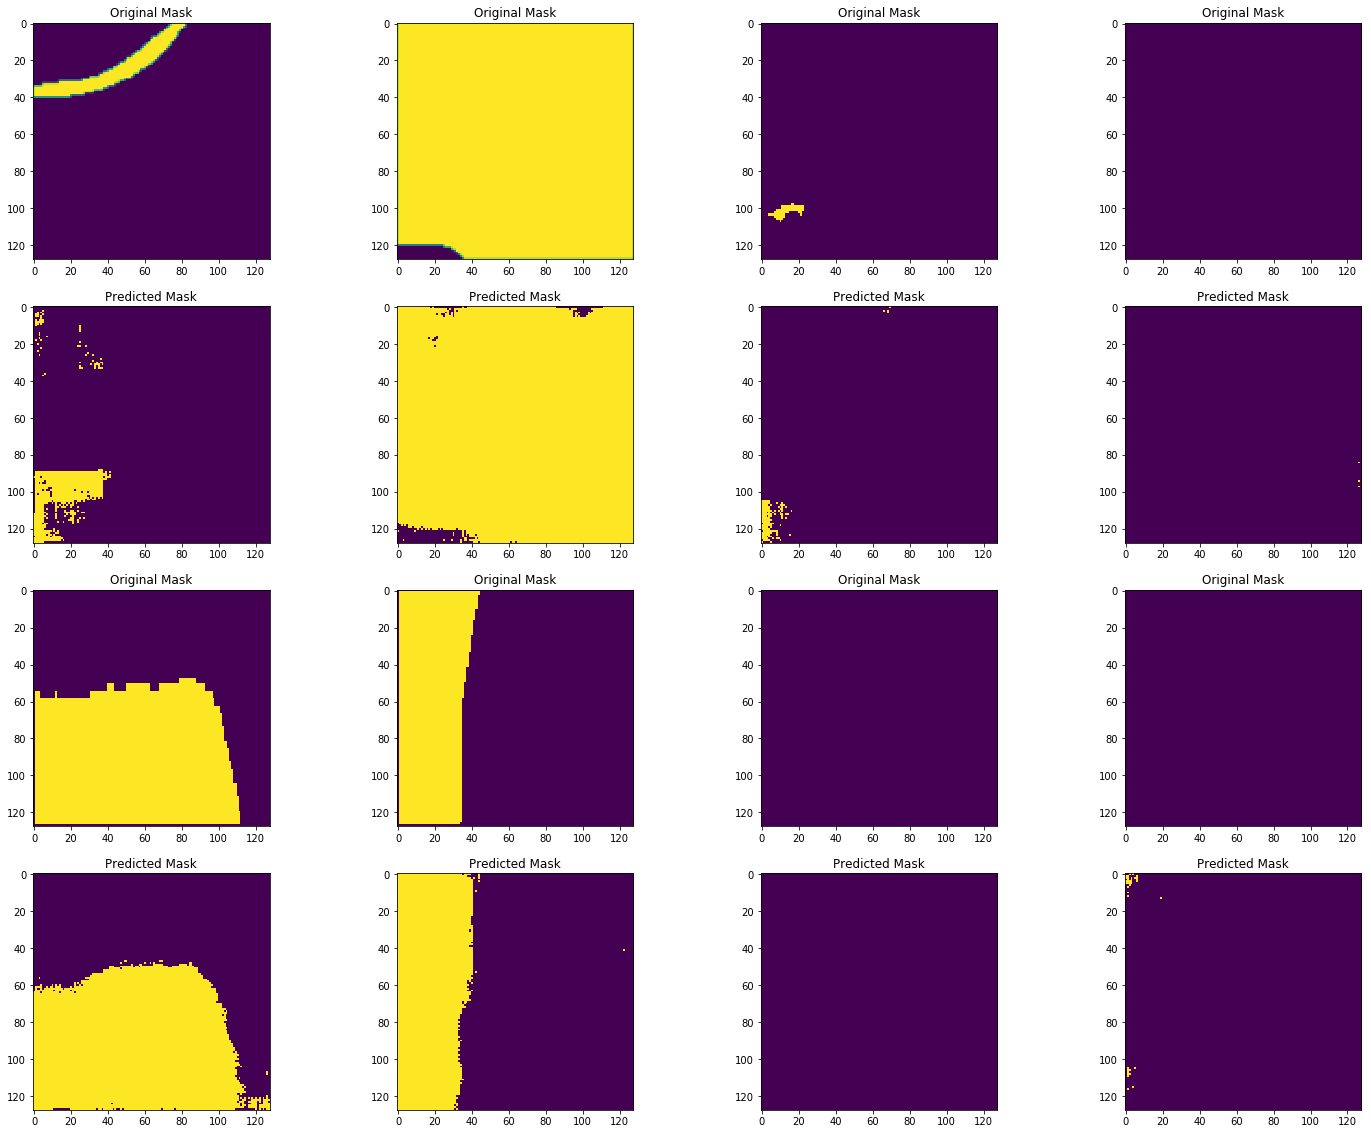

Threshold: 0.5


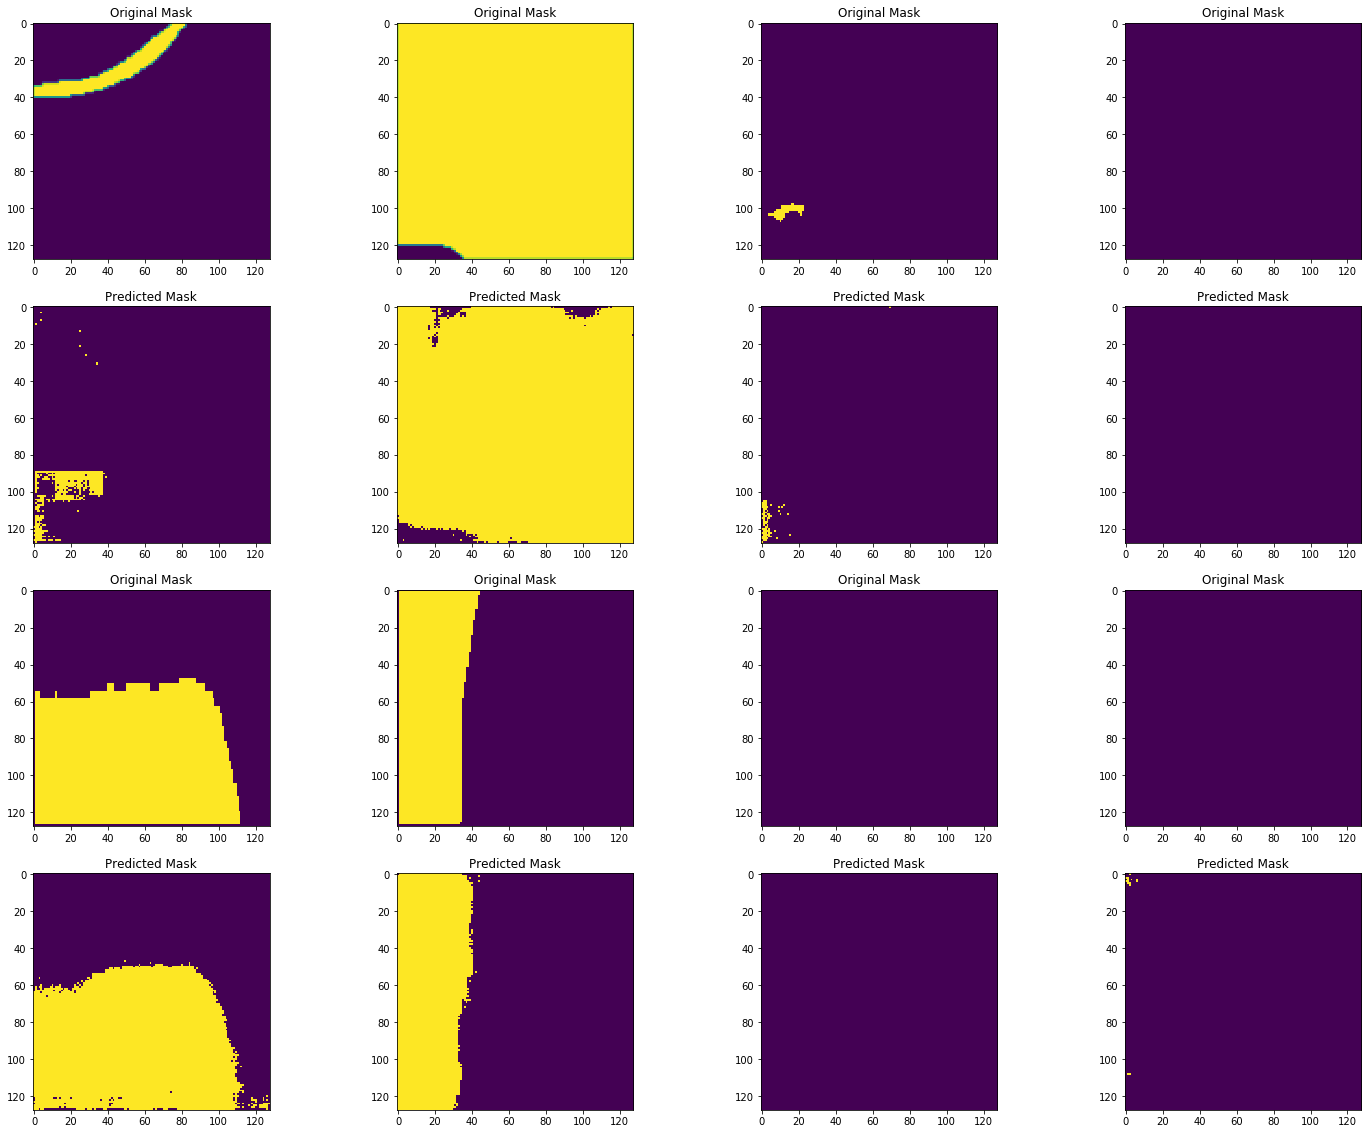

Threshold: 0.6


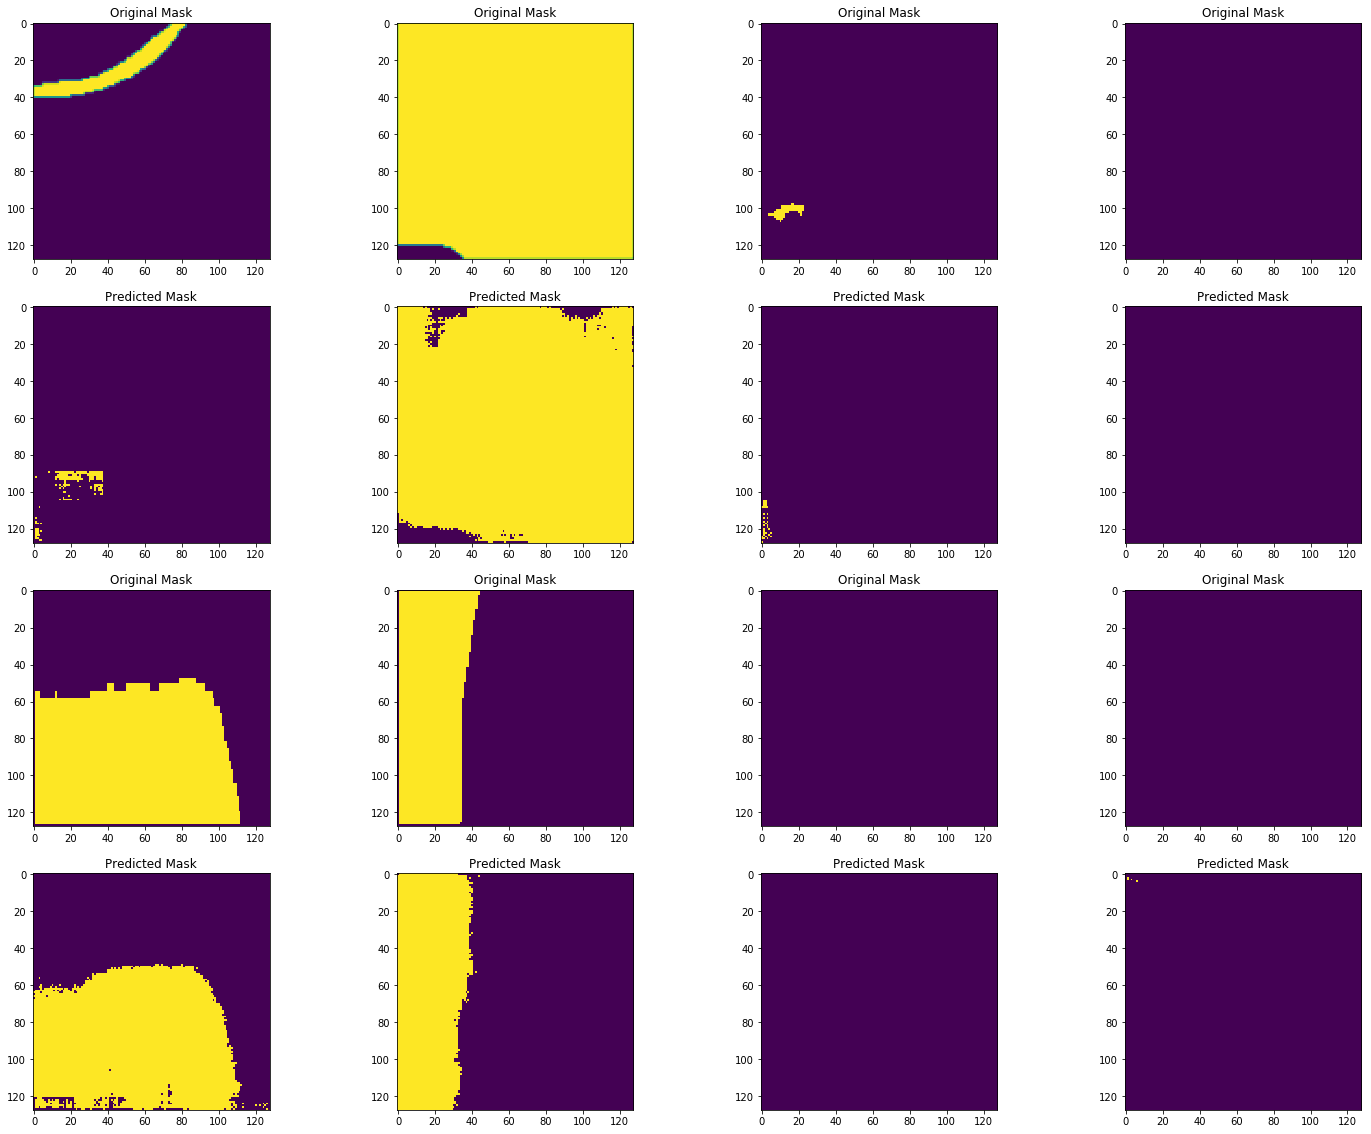

In [31]:
indices = np.array(list(range(16,24)))
plot_masks_and_predicted_masks(mask_validation, mask_predicted, indices, 0.01)
plot_masks_and_predicted_masks(mask_validation, mask_predicted, indices, 0.05)
plot_masks_and_predicted_masks(mask_validation, mask_predicted, indices, 0.1)
plot_masks_and_predicted_masks(mask_validation, mask_predicted, indices, 0.3)
plot_masks_and_predicted_masks(mask_validation, mask_predicted, indices, 0.4)
plot_masks_and_predicted_masks(mask_validation, mask_predicted, indices, 0.5)
plot_masks_and_predicted_masks(mask_validation, mask_predicted, indices, 0.6)

Threshold: 0.01


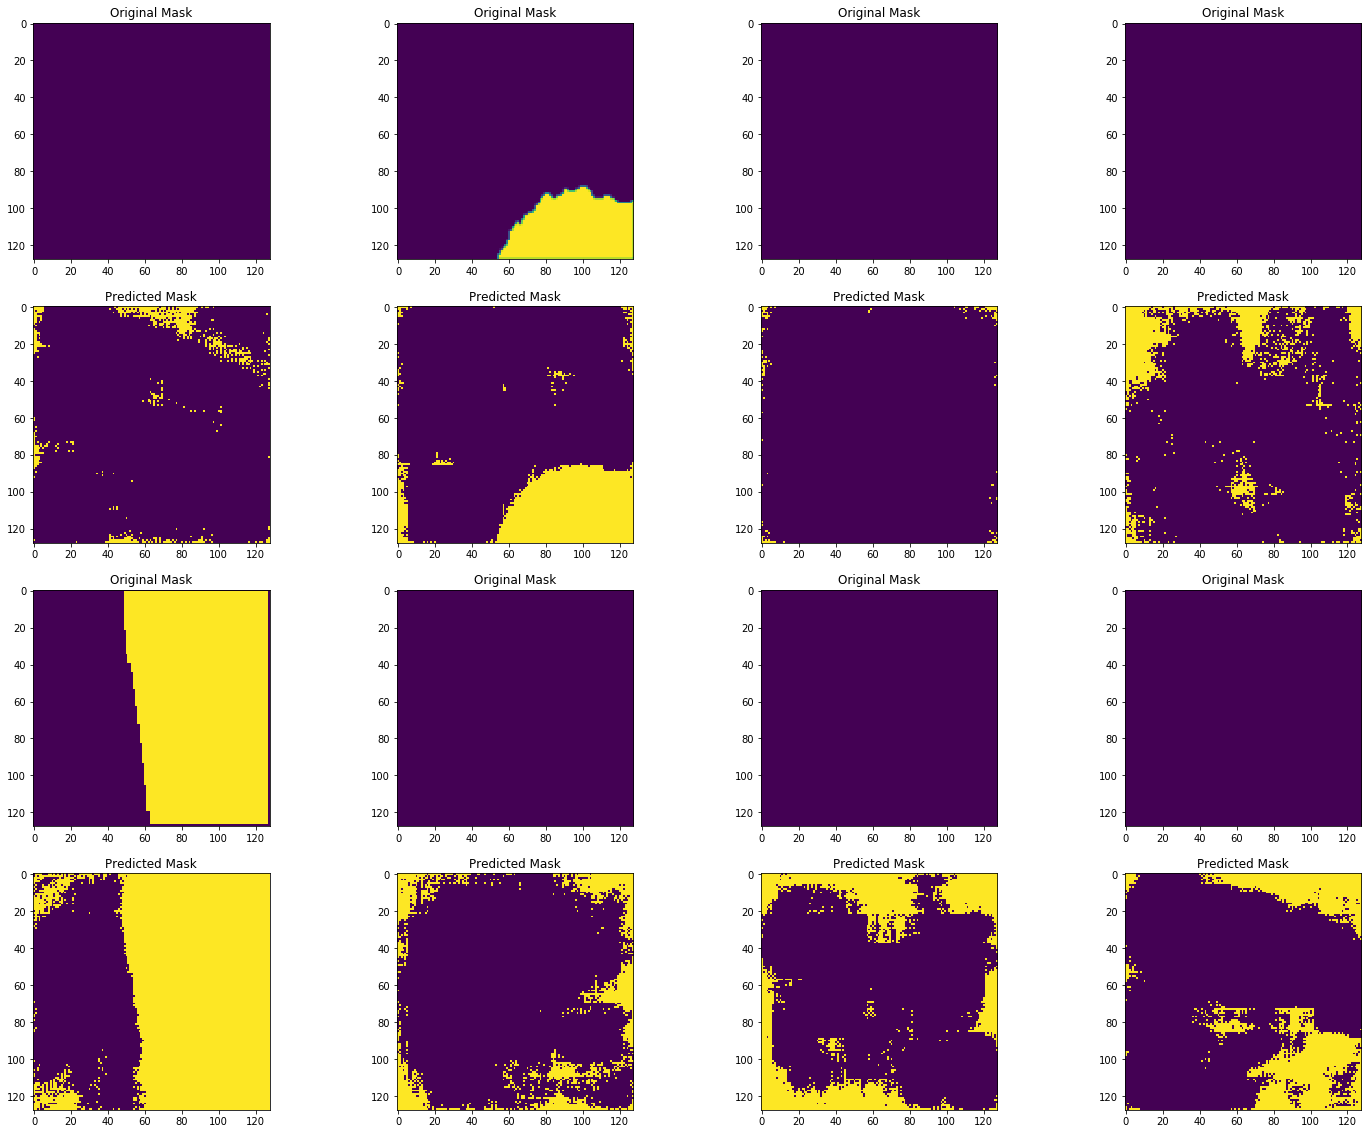

Threshold: 0.05


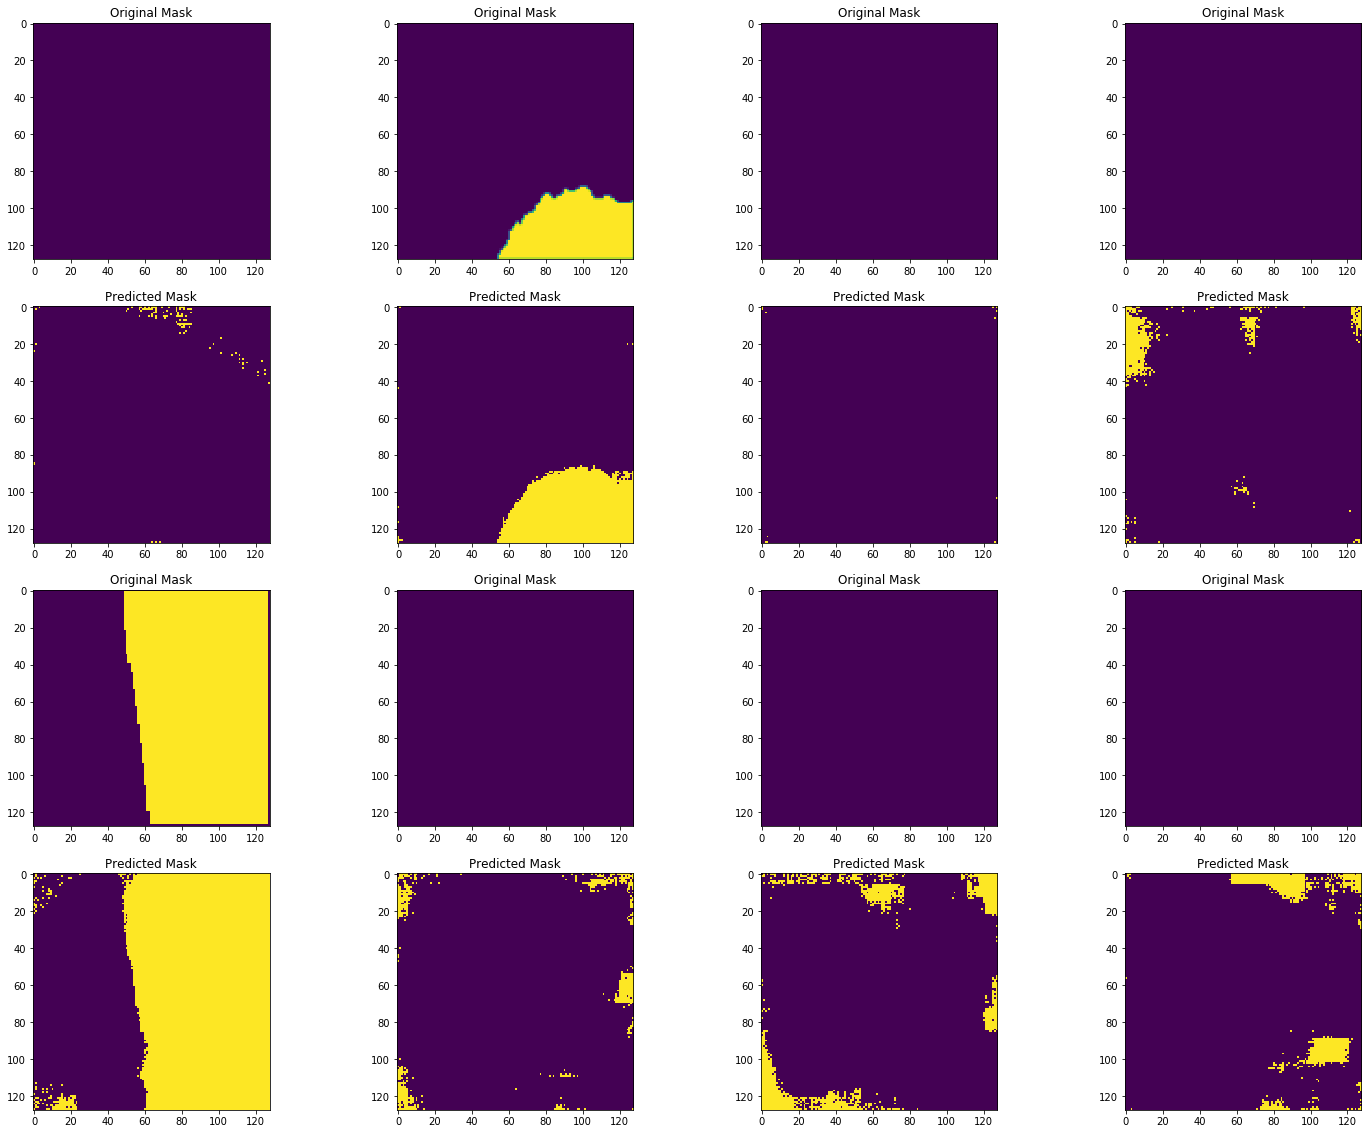

Threshold: 0.1


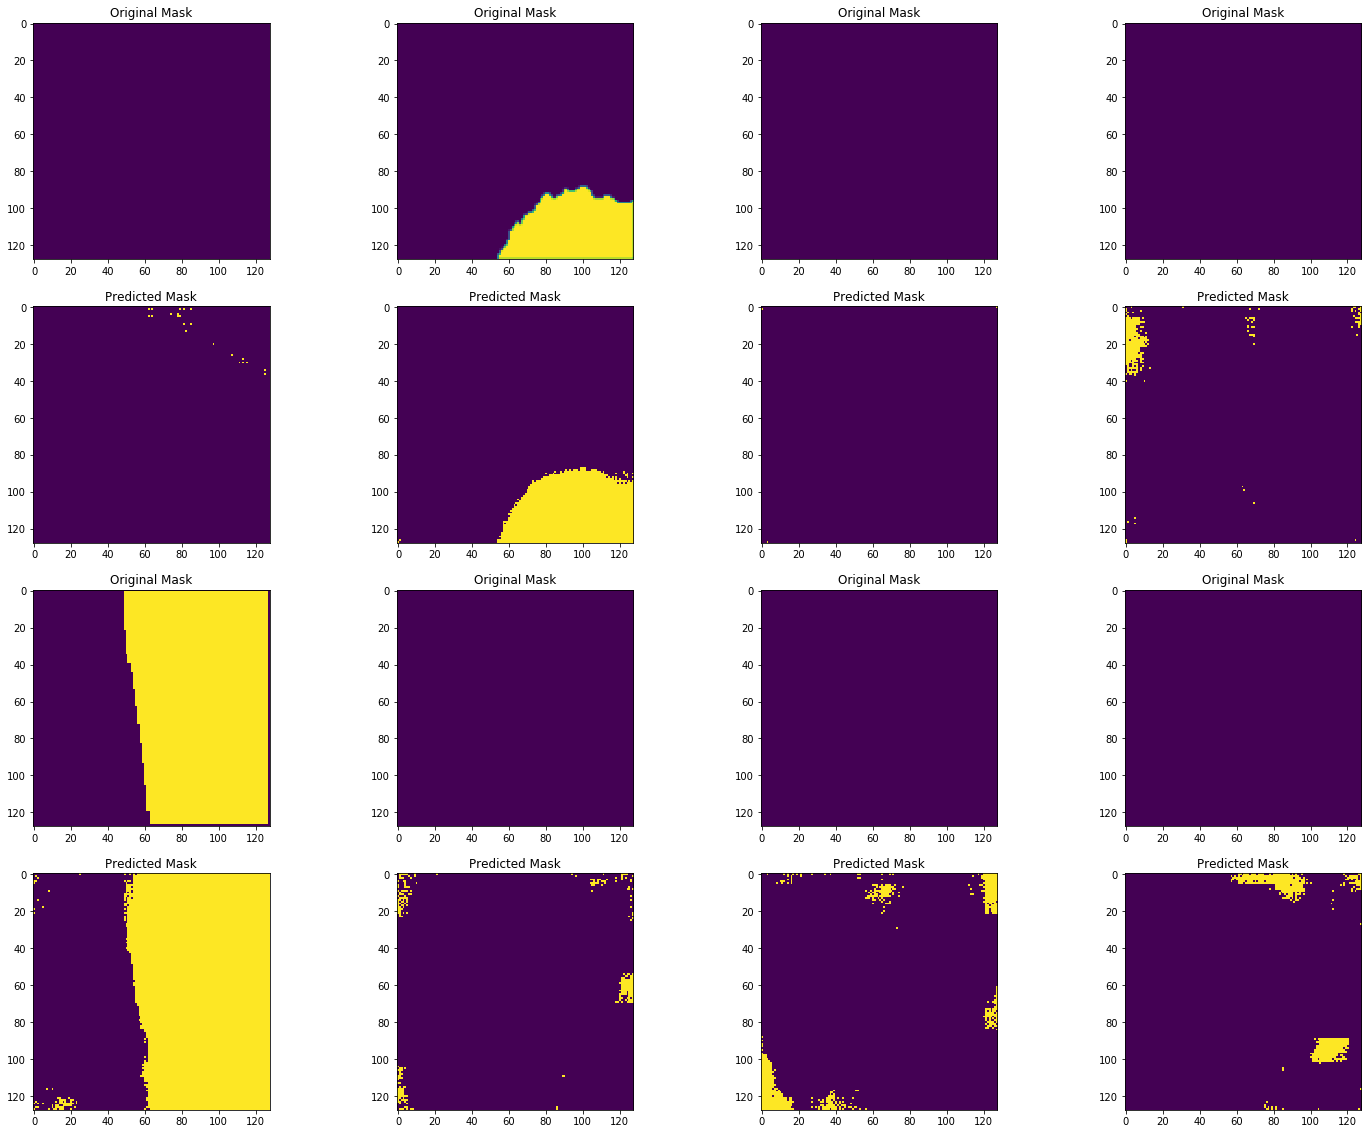

Threshold: 0.3


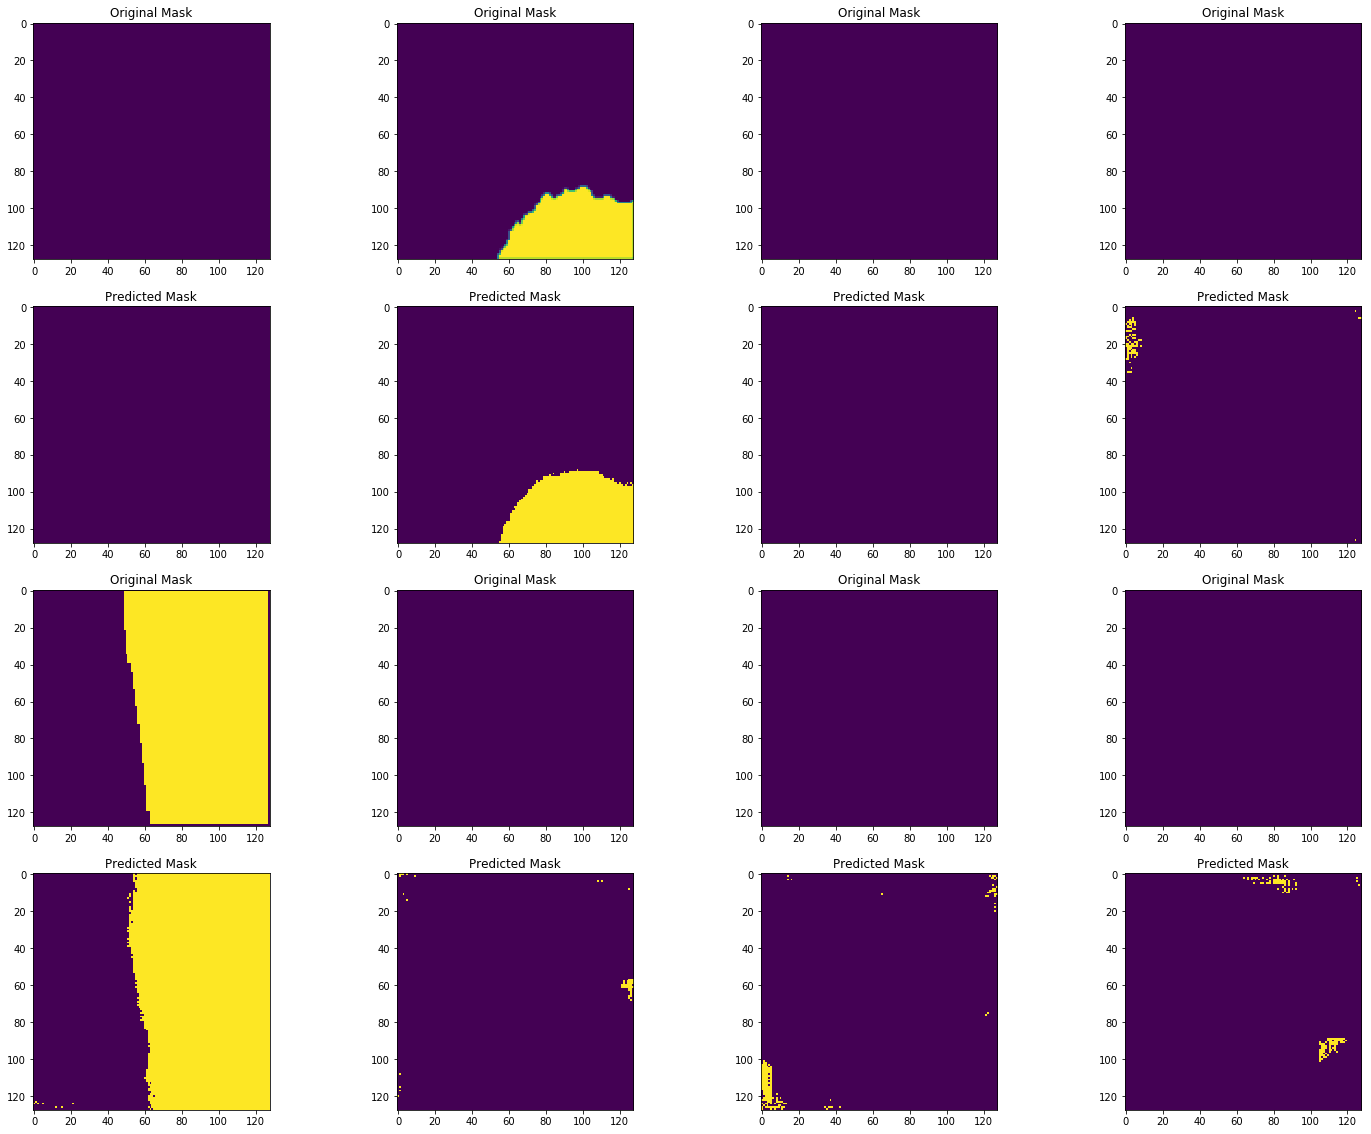

Threshold: 0.4


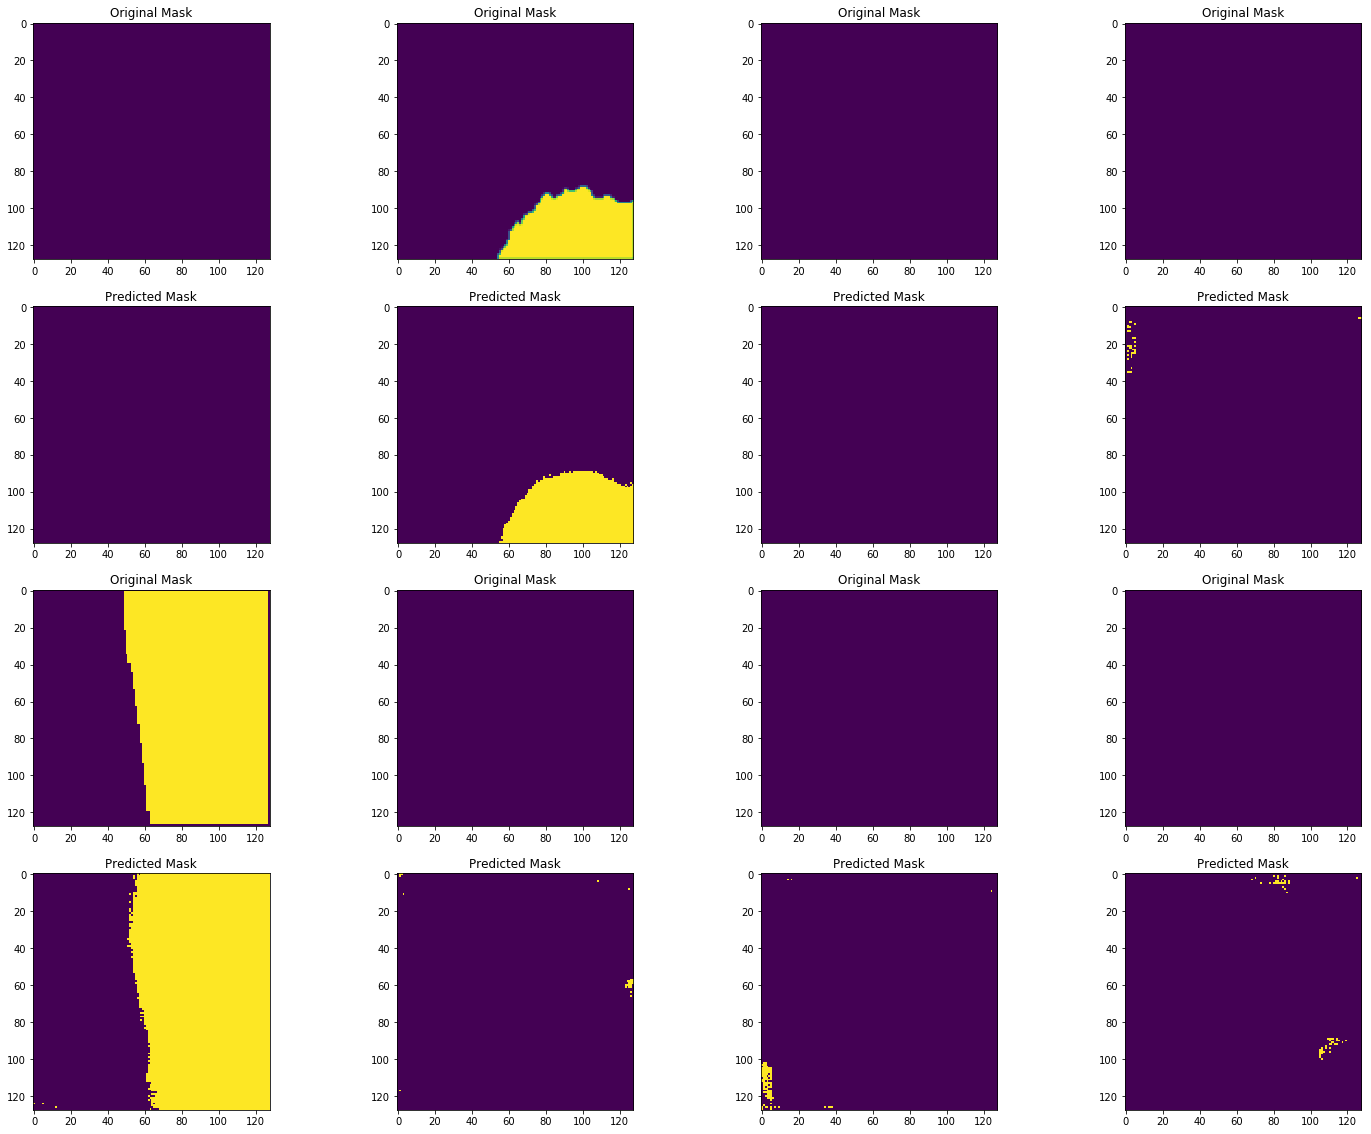

Threshold: 0.5


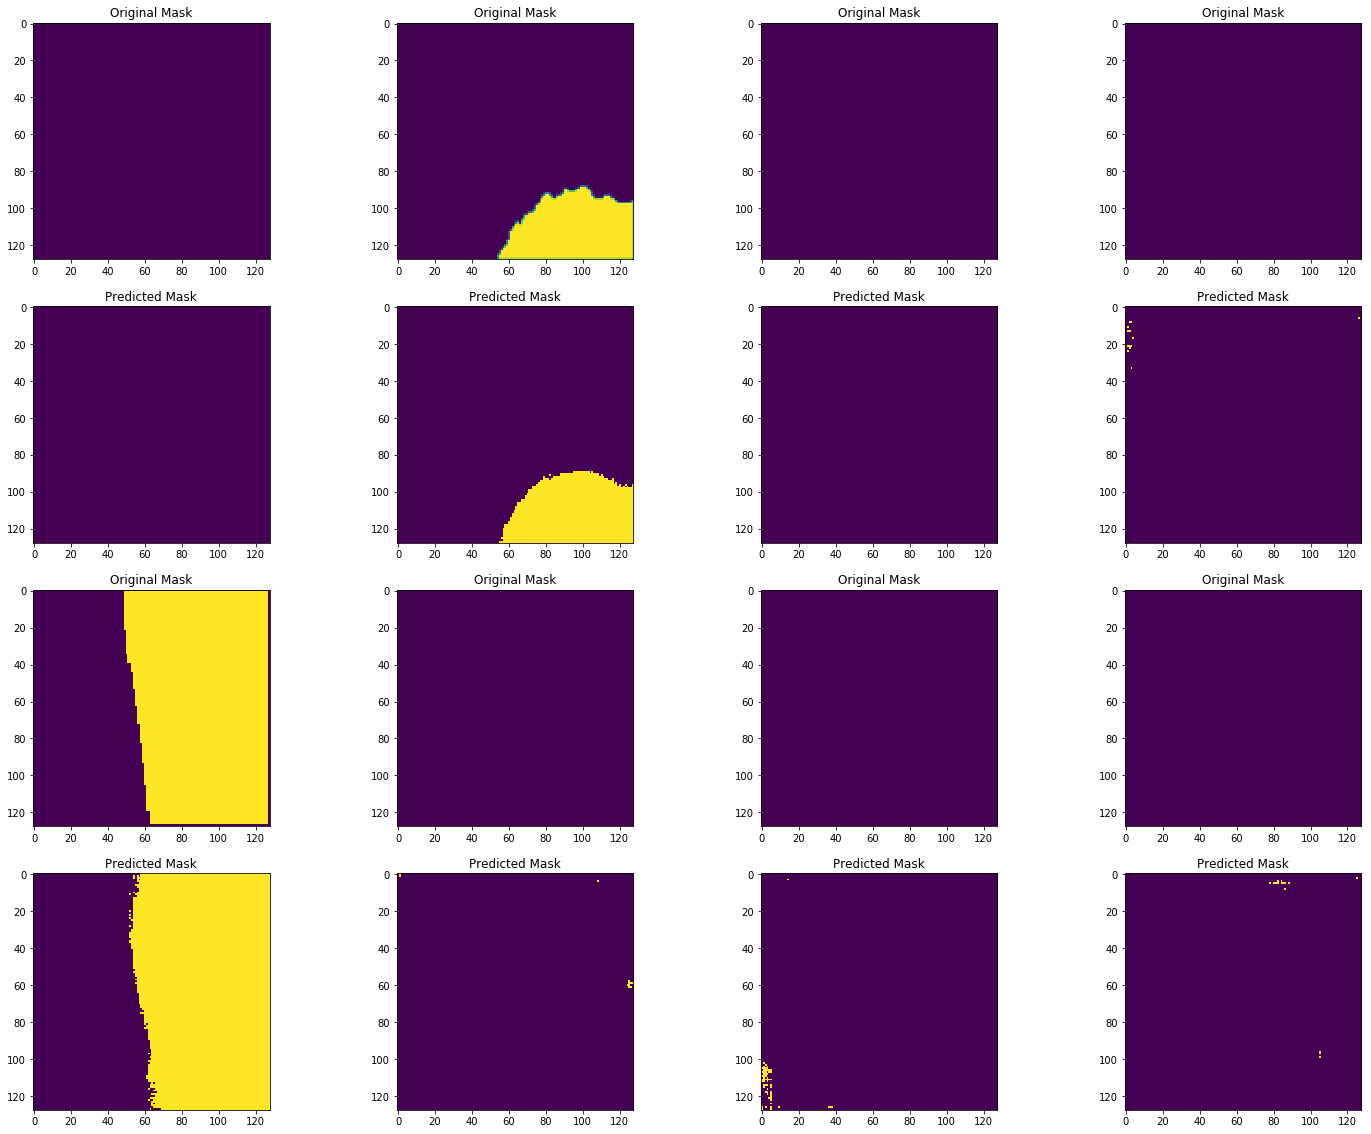

Threshold: 0.6


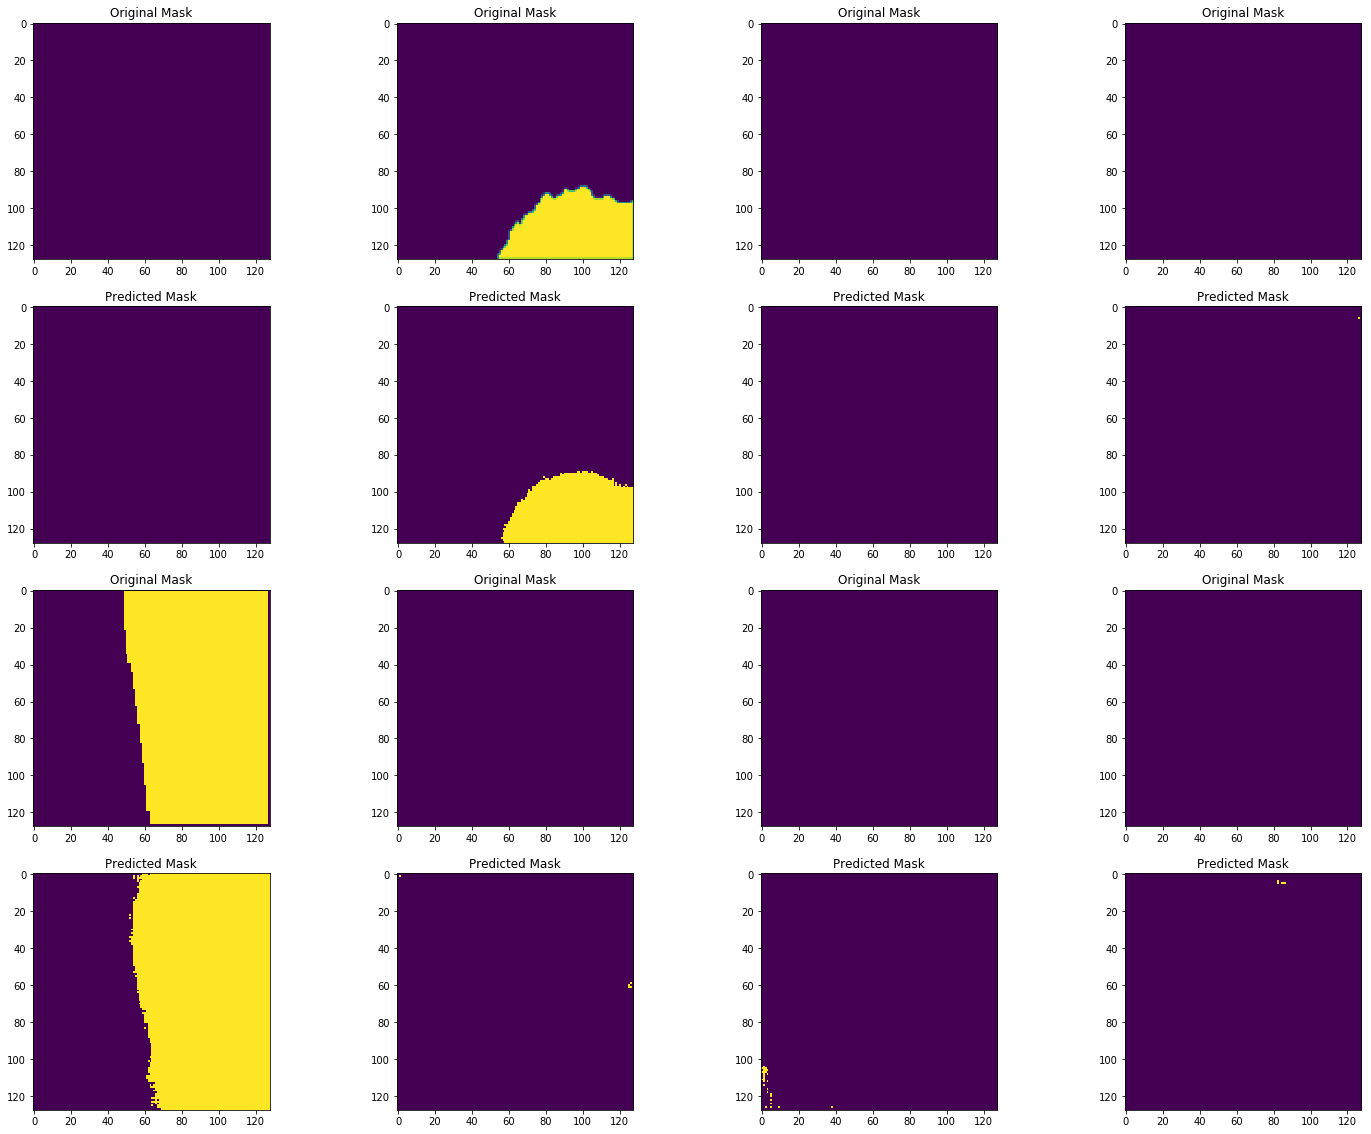

In [32]:
indices = np.array(list(range(24,32)))
plot_masks_and_predicted_masks(mask_validation, mask_predicted, indices, 0.01)
plot_masks_and_predicted_masks(mask_validation, mask_predicted, indices, 0.05)
plot_masks_and_predicted_masks(mask_validation, mask_predicted, indices, 0.1)
plot_masks_and_predicted_masks(mask_validation, mask_predicted, indices, 0.3)
plot_masks_and_predicted_masks(mask_validation, mask_predicted, indices, 0.4)
plot_masks_and_predicted_masks(mask_validation, mask_predicted, indices, 0.5)
plot_masks_and_predicted_masks(mask_validation, mask_predicted, indices, 0.6)

## 6. Create and inspect submission file

**Create and save submission file**

In [33]:
model_path = model_dir+"my-model-"+str(best_iteration)
submission_path = "./submission_files/submission.csv"
threshold = 0.5
n_folds = 100
create_predictions(model_path, X, training, test_ids, n_folds, threshold, submission_path)

INFO:tensorflow:Restoring parameters from ./model_files/my-model-2997


[100%]|####################################|(number_of_folds_completed:    100)


**Inspect the submission csv**

In [34]:
submission = pd.read_csv(submission_path)
submission.head(50)

,id,rle_mask
0,fe9ef2e02d.png,91 1 221 1 601 1 1624 1 2259 1 2261 3 2386 2 2...
1,ef36c47553.png,1900 1 1904 1 2030 1 2033 1 2417 1 4590 1 4711...
2,79e562058a.png,3 1 5 1 133 1 211 1 214 2 470 1 514 1 653 1 66...
3,170791a419.png,138 1 396 1 650 1 8003 1 8253 1 8259 1 8512 1 ...
4,0fbf301a5e.png,93 1 121 3 126 1 247 7 255 1 377 1 379 4 502 1...
5,32034f14af.png,385 1 8319 1 8447 1 8574 1 8829 1 8955 5 9085 ...
6,2d2f28610a.png,46 1 49 2 52 24 77 2 80 3 86 1 88 41 169 88 29...
7,09393f1bb5.png,53 1 182 2 308 1 566 1 692 1 697 1 820 1 822 2...
8,65bb27f932.png,2 7 129 2 132 14 147 3 257 10 268 2 271 1 385 ...
9,fa93747e87.png,4988 1 4991 1 5119 1 5247 1 5370 6 5495 1 5498...


In [35]:
print("shape of submission file:", submission.shape)
print("Number of test images:", len(test_ids))

shape of submission file: (18000, 2)
Number of test images: 18000
